# What's in this notebook
- Exploratory and comparison work between the different sentiment models.
- Simple correlations of Chat GPT, FinBERT, and CentralBankRoberta with daily, monthly, and quarterly indicators.

# Libraries

In [6]:
# Import relevant libraries.
import gdown
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates

import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import contractions
import re
from nltk import word_tokenize, pos_tag
from nltk.tokenize import sent_tokenize
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import scipy
import torch

import pickle

# Open AI
import openai
import time

# Functions

### Charting functions

In [9]:
# BoE colours
boe_cols = ['#3CD7D9', '#FF7300', '#9E71FE', '#A5D700', '#FF50C8']

In [10]:
# Function for correct x-axis display in timelines - FULL TIME PERIOD

def year_format(df, date_col=None, fontsize=12):
    ax = plt.gca()

    dates = df[date_col] if date_col else df.index
    datemin = dates.min().replace(month=1, day=1)
    datemax = dates.max().replace(month=1, day=1) + pd.DateOffset(years=1)

    ax.set_xlim(datemin, datemax)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=90)

    # Sent font size
    plt.xticks(fontsize=fontsize)

In [11]:
# Function for correct x-axis display in timelines - PAST TEN YEARS

def year_format_pten(df, date_col=None, fontsize=12):
    ax = plt.gca()

    dates = df[date_col] if date_col else df.index
    datemin = dates.min().replace(month=1, day=1)
    datemax = dates.max().replace(month=1, day=1)

    ax.set_xlim(datemin, datemax)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Sent font size
    plt.xticks(fontsize=fontsize)

In [12]:
# Function to display events and focus areas on timelines - FULL TIME PERIOD

def milestones(ax=None, label_position=0.8):
    # Use current axis if none provided
    if ax is None:
        ax = plt.gca()
        
    y_max = ax.get_ylim()[1]
    y_min = ax.get_ylim()[0]
    
    # Calculate label position based on parameter
    label_y_position = y_min + (y_max - y_min) * label_position
    
    # Predefined highlight periods
    highlight_periods = {
        'Dot-Com Bubble Burst\n(2000–2002)': ('2000', '2002'),
        'Global Financial Crisis\n(2007–2008)': ('2007', '2008'),
        'Eurozone Debt Crisis\n(2009–2012)': ('2009', '2012'),
        'COVID Pandemic\n(2020–2022)': ('2020', '2022')
        # ,
        # 'Geopolitical Tensions (2022-2025)': (2022, 2025)
    }
    
    # Predefined event lines
    event_lines = {
        'Launch of the Euro (1999)': '1999',
        'Terror Attacks (2001-09-11)': '2001-09-11',
        'Brexit Referendum (2016)': '2016',
        'Brexit (2020)': '2020',
        'Supply Chain Crisis (2021)': '2021',
        'Ukraine Invasion. UK Mini-Budget (2022)': '2022',
    }
    
    # Add highlighted time periods
    for label, (start, end) in highlight_periods.items():
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)
        ax.axvspan(start_date, end_date, color='grey', alpha=0.2)
        # Use the adjustable position for labels
        ax.text((start_date + (end_date - start_date)/2), label_y_position, 
               label, ha='center', va='center', fontsize=11)
    
    # Add event lines
    for label, date in event_lines.items():
        event_date = pd.to_datetime(date)
        ax.axvline(event_date, color='black', linestyle='--', linewidth=0.8)
        ax.text(event_date, y_max*0.85, label, rotation=90, 
               va='top', ha='left', fontsize=12)

In [209]:
# Function to display events and focus areas on timelines - PAST TEN YEARS

def milestones_pten(ax=None, label_position=0.8):
    # Use current axis if none provided
    if ax is None:
        ax = plt.gca()
        
    y_max = ax.get_ylim()[1]
    y_min = ax.get_ylim()[0]
    
    # Calculate label position based on parameter
    label_y_position = y_min + (y_max - y_min) * label_position
    
    # Highlight periods
    highlight_periods = {
        'COVID Pandemic\n(2020–2022)': ('2020', '2022')
        # ,
        # 'Geopolitical Tensions (2022-2025)': (2022, 2025)
    }
    
    # Event lines
    event_lines = {
        'Brexit Referendum (2016)': '2016',
        'Brexit (2020)': '2020',
        'Supply Chain Crisis (2021)': '2021',
        'Ukraine Invasion. UK Mini-Budget (2022)': '2022',
    }
    
    # Add highlighted time periods
    for label, (start, end) in highlight_periods.items():
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)
        ax.axvspan(start_date, end_date, color='grey', alpha=0.2)
        # Use the adjustable position for labels
        ax.text((start_date + (end_date - start_date)/2), label_y_position, 
               label, ha='center', va='center', fontsize=9)
    
    # Add event lines
    for label, date in event_lines.items():
        event_date = pd.to_datetime(date)
        ax.axvline(event_date, color='black', linestyle='--', linewidth=0.8)
        ax.text(event_date, y_max*0.85, label, rotation=90, 
               va='top', ha='left', fontsize=12)

In [14]:
# Add gridlines to visualisations

def gridlines():
    plt.grid(True, linestyle='--', alpha=0.3)

### NLP functions

In [16]:
# Text cleaning function

def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Collapse extra whitespace
    # Set stop words with negation
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text.strip()

In [17]:
# Lemmatising function

# Define the tag map for POS tagging
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Lemmatise the tokens with correct POS tags
lemma_function = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    #For each word in the token list, it lemmatizes the word with the correct part-of-speech
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return lemmatized_tokens

# Data import

In [19]:
# https://drive.google.com/file/d/1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD/view?usp=drive_link 
# Master Data set uk_speeches_cleaned_v2 13/05/25
file_id = '1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD'

# Create the direct download link
download_url = f"https://drive.google.com/uc?id={file_id}"

# Download the file locally
output_path = 'uk_speeches_cleaned_v2_local.csv'
gdown.download(download_url, output_path, quiet=False)

# Read the downloaded CSV
uk_data = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD
To: C:\Users\katej\Desktop\LSE Data Analytics\4. Employer Project\BoE-Beacon\uk_speeches_cleaned_v2_local.csv
100%|██████████| 30.9M/30.9M [00:01<00:00, 29.1MB/s]


In [20]:
uk_data.info()
uk_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   custom_ref  1365 non-null   object 
 1   reference   1200 non-null   object 
 2   country     1365 non-null   object 
 3   date        1365 non-null   object 
 4   title       1365 non-null   object 
 5   author      1365 non-null   object 
 6   is_gov      1365 non-null   float64
 7   text        1365 non-null   object 
dtypes: float64(1), object(7)
memory usage: 85.4+ KB


custom_ref     reference country        date  \
0   UK_1998-09-15_George  r980915a_BOE      UK  1998-09-15   
1   UK_1998-10-21_George  r981021b_BOE      UK  1998-10-21   
2     UK_1998-10-21_King  r981021a_BOE      UK  1998-10-21   
3     UK_1998-11-01_budd  r981101a_BOE      UK  1998-11-01   
4  UK_1998-11-01_vickers  r981101b_BOE      UK  1998-11-01   

                                               title         author  is_gov  \
0                                             Speech  Edward George     1.0   
1                                  Britain in Europe  Edward George     1.0   
2  Impact of the recent turbulence in internation...    Mervyn King     0.0   
3        Economic policy, with and without forecasts           budd     0.0   
4  Inflation targeting in practice: the UK experi...        vickers     0.0   

                                                text  
0  Thank you, Chairman. I'm actually very pleased...  
1  It's a great pleasure to be here in the beauti...  
2  Few industries have suffered more from volatil...  
3  My topic this evening is the use of forecasts ...  
4  Six years ago this week, sterling left the exc...

In [21]:
# Convert to datetime
uk_data['date'] = pd.to_datetime(uk_data['date'])
uk_data.head()

custom_ref     reference country       date  \
0   UK_1998-09-15_George  r980915a_BOE      UK 1998-09-15   
1   UK_1998-10-21_George  r981021b_BOE      UK 1998-10-21   
2     UK_1998-10-21_King  r981021a_BOE      UK 1998-10-21   
3     UK_1998-11-01_budd  r981101a_BOE      UK 1998-11-01   
4  UK_1998-11-01_vickers  r981101b_BOE      UK 1998-11-01   

                                               title         author  is_gov  \
0                                             Speech  Edward George     1.0   
1                                  Britain in Europe  Edward George     1.0   
2  Impact of the recent turbulence in internation...    Mervyn King     0.0   
3        Economic policy, with and without forecasts           budd     0.0   
4  Inflation targeting in practice: the UK experi...        vickers     0.0   

                                                text  
0  Thank you, Chairman. I'm actually very pleased...  
1  It's a great pleasure to be here in the beauti...  
2  Few industries have suffered more from volatil...  
3  My topic this evening is the use of forecasts ...  
4  Six years ago this week, sterling left the exc...

# Text prep

In [23]:
# Apply the cleaning function
uk_data['clean_text'] = uk_data['text'].apply(preprocess_text)
uk_data.head()

custom_ref     reference country       date  \
0   UK_1998-09-15_George  r980915a_BOE      UK 1998-09-15   
1   UK_1998-10-21_George  r981021b_BOE      UK 1998-10-21   
2     UK_1998-10-21_King  r981021a_BOE      UK 1998-10-21   
3     UK_1998-11-01_budd  r981101a_BOE      UK 1998-11-01   
4  UK_1998-11-01_vickers  r981101b_BOE      UK 1998-11-01   

                                               title         author  is_gov  \
0                                             Speech  Edward George     1.0   
1                                  Britain in Europe  Edward George     1.0   
2  Impact of the recent turbulence in internation...    Mervyn King     0.0   
3        Economic policy, with and without forecasts           budd     0.0   
4  Inflation targeting in practice: the UK experi...        vickers     0.0   

                                                text  \
0  Thank you, Chairman. I'm actually very pleased...   
1  It's a great pleasure to be here in the beauti...   
2  Few industries have suffered more from volatil...   
3  My topic this evening is the use of forecasts ...   
4  Six years ago this week, sterling left the exc...   

                                          clean_text  
0  thank chairman actually pleased opportunity re...  
1  great pleasure beautiful city bruges honoured ...  
2  industries suffered volatility british economy...  
3  topic evening use forecasts economic policy ma...  
4  six years ago week sterling left exchange rate...

In [24]:
# Tokenise
uk_data['tokens'] = uk_data['clean_text'].apply(word_tokenize)
uk_data.head()

custom_ref     reference country       date  \
0   UK_1998-09-15_George  r980915a_BOE      UK 1998-09-15   
1   UK_1998-10-21_George  r981021b_BOE      UK 1998-10-21   
2     UK_1998-10-21_King  r981021a_BOE      UK 1998-10-21   
3     UK_1998-11-01_budd  r981101a_BOE      UK 1998-11-01   
4  UK_1998-11-01_vickers  r981101b_BOE      UK 1998-11-01   

                                               title         author  is_gov  \
0                                             Speech  Edward George     1.0   
1                                  Britain in Europe  Edward George     1.0   
2  Impact of the recent turbulence in internation...    Mervyn King     0.0   
3        Economic policy, with and without forecasts           budd     0.0   
4  Inflation targeting in practice: the UK experi...        vickers     0.0   

                                                text  \
0  Thank you, Chairman. I'm actually very pleased...   
1  It's a great pleasure to be here in the beauti...   
2  Few industries have suffered more from volatil...   
3  My topic this evening is the use of forecasts ...   
4  Six years ago this week, sterling left the exc...   

                                          clean_text  \
0  thank chairman actually pleased opportunity re...   
1  great pleasure beautiful city bruges honoured ...   
2  industries suffered volatility british economy...   
3  topic evening use forecasts economic policy ma...   
4  six years ago week sterling left exchange rate...   

                                              tokens  
0  [thank, chairman, actually, pleased, opportuni...  
1  [great, pleasure, beautiful, city, bruges, hon...  
2  [industries, suffered, volatility, british, ec...  
3  [topic, evening, use, forecasts, economic, pol...  
4  [six, years, ago, week, sterling, left, exchan...

# Speech length

In [41]:
# Set date as index
uk_data = uk_data.set_index('date')

In [43]:
# Add column for count of all tokens
uk_data['length'] = uk_data['tokens'].apply(len) # Total number of tokens/words
uk_data.head()

custom_ref     reference country  \
date                                                      
1998-09-15   UK_1998-09-15_George  r980915a_BOE      UK   
1998-10-21   UK_1998-10-21_George  r981021b_BOE      UK   
1998-10-21     UK_1998-10-21_King  r981021a_BOE      UK   
1998-11-01     UK_1998-11-01_budd  r981101a_BOE      UK   
1998-11-01  UK_1998-11-01_vickers  r981101b_BOE      UK   

                                                        title         author  \
date                                                                           
1998-09-15                                             Speech  Edward George   
1998-10-21                                  Britain in Europe  Edward George   
1998-10-21  Impact of the recent turbulence in internation...    Mervyn King   
1998-11-01        Economic policy, with and without forecasts           budd   
1998-11-01  Inflation targeting in practice: the UK experi...        vickers   

            is_gov                                               text  \
date                                                                    
1998-09-15     1.0  Thank you, Chairman. I'm actually very pleased...   
1998-10-21     1.0  It's a great pleasure to be here in the beauti...   
1998-10-21     0.0  Few industries have suffered more from volatil...   
1998-11-01     0.0  My topic this evening is the use of forecasts ...   
1998-11-01     0.0  Six years ago this week, sterling left the exc...   

                                                   clean_text  \
date                                                            
1998-09-15  thank chairman actually pleased opportunity re...   
1998-10-21  great pleasure beautiful city bruges honoured ...   
1998-10-21  industries suffered volatility british economy...   
1998-11-01  topic evening use forecasts economic policy ma...   
1998-11-01  six years ago week sterling left exchange rate...   

                                                       tokens  length  
date                                                                   
1998-09-15  [thank, chairman, actually, pleased, opportuni...    1162  
1998-10-21  [great, pleasure, beautiful, city, bruges, hon...    2108  
1998-10-21  [industries, suffered, volatility, british, ec...    1240  
1998-11-01  [topic, evening, use, forecasts, economic, pol...    2380  
1998-11-01  [six, years, ago, week, sterling, left, exchan...    2580

In [45]:
# Save to csv
# length = uk_data[['custom_ref', 'length']]
# length.to_csv('speech_length.csv', index=False)

In [49]:
# Resample and set rolling average
month_length_avg = uk_data['length'].resample('ME').mean().dropna()
length_rolling = month_length_avg.rolling(window=6, min_periods=6).mean()
# ema = monthly_length_avg.ewm(span=6, adjust=False).mean()

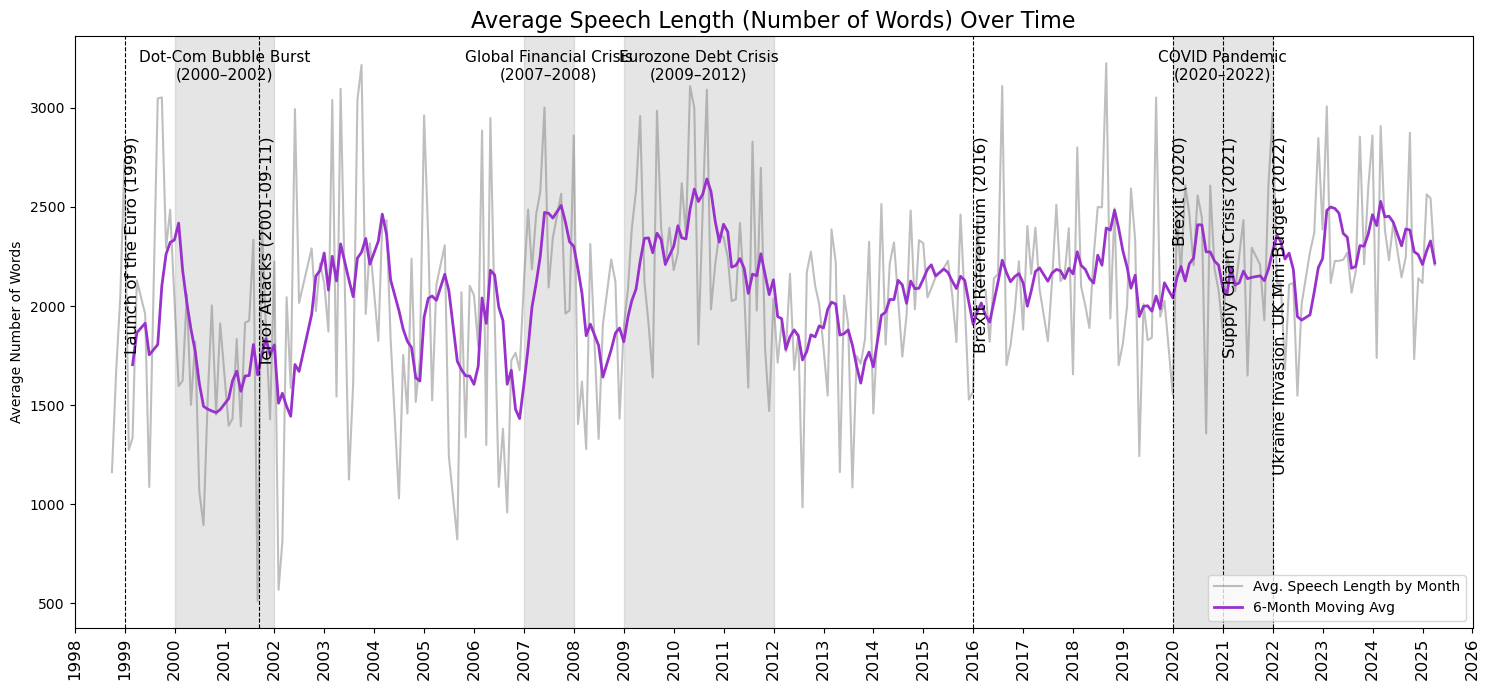

In [51]:
fig, ax = plt.subplots(figsize=(15,7))

ax.plot(month_length_avg, label='Avg. Speech Length by Month', color='grey', alpha=0.5)
ax.plot(length_rolling, label='6-Month Moving Avg', color='darkorchid', linewidth=2)

plt.title('Average Speech Length (Number of Words) Over Time', fontsize=16)
plt.ylabel('Average Number of Words')

# gridlines()
year_format(month_length_avg)
milestones(label_position=0.95)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [52]:
uk_data['length'].describe()

count    1365.000000
mean     2074.520147
std       800.069754
min       121.000000
25%      1421.000000
50%      2091.000000
75%      2891.000000
max      3541.000000
Name: length, dtype: float64

**Observation:** 
- In general, speeches are between 1,400 and 2,900 words.
- The Eurozone Debt Crisis period resulted in the longest average speeches.

# BoE sentiment labels

In [57]:
boesl_data = uk_data.copy()

In [59]:
# Load BoE Wordlist
wordlist = df = pd.read_csv('../Data/boe_wordlist.csv')

In [61]:
print(wordlist.info())
wordlist.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          3880 non-null   object
 1   Negative      3880 non-null   int64 
 2   Positive      3880 non-null   int64 
 3   Uncertainty   3880 non-null   int64 
 4   Litigious     3880 non-null   int64 
 5   Strong        3880 non-null   int64 
 6   Weak          3880 non-null   int64 
 7   Constraining  3880 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 242.6+ KB
None


Word  Negative  Positive  Uncertainty  Litigious  Strong  Weak  \
0       ABANDON         1         0            0          0       0     0   
1     ABANDONED         1         0            0          0       0     0   
2    ABANDONING         1         0            0          0       0     0   
3   ABANDONMENT         1         0            0          0       0     0   
4  ABANDONMENTS         1         0            0          0       0     0   

   Constraining  
0             0  
1             0  
2             0  
3             0  
4             0

In [63]:
wordlist.describe()

Negative     Positive  Uncertainty    Litigious       Strong  \
count  3880.000000  3880.000000  3880.000000  3880.000000  3880.000000   
mean      0.606959     0.092268     0.076546     0.233247     0.004897   
std       0.488489     0.289441     0.265905     0.422953     0.069815   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              Weak  Constraining  
count  3880.000000   3880.000000  
mean      0.006959      0.047423  
std       0.083139      0.212569  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      0.000000  
max       1.000000      1.000000

In [65]:
# Convert words to lowercase
wordlist['Word'] = wordlist['Word'].str.lower()
wordlist.head()

Word  Negative  Positive  Uncertainty  Litigious  Strong  Weak  \
0       abandon         1         0            0          0       0     0   
1     abandoned         1         0            0          0       0     0   
2    abandoning         1         0            0          0       0     0   
3   abandonment         1         0            0          0       0     0   
4  abandonments         1         0            0          0       0     0   

   Constraining  
0             0  
1             0  
2             0  
3             0  
4             0

## Apply wordlist to main data

In [68]:
# Add columns for counts of words in all categories
categories = ['Negative', 'Positive', 'Uncertainty', 
              'Litigious', 'Strong', 'Weak', 'Constraining']

for cat in categories:
    word_set = set(wordlist[wordlist[cat] == 1]['Word']) # Create a set for words in each sentiment category
    col_name = f'n_{cat.lower()}' # Create column name
    boesl_data[col_name] = boesl_data['tokens'].apply(lambda x: sum(word in word_set for word in x)) # Count words in each speech

In [69]:
boesl_data.sample(3)

custom_ref     reference country  \
date                                                       
2011-03-31     UK_2011-03-31_miles  r110331a_BOE      UK   
2010-07-13  UK_2010-07-13_sentance  r100713b_BOE      UK   
2011-02-18      UK_2011-02-18_King  r110218b_BOE      UK   

                                                        title       author  \
date                                                                         
2011-03-31    Mortgages and housing in the near and long term        miles   
2010-07-13                                 UK Monetary Policy     sentance   
2011-02-18  Global imbalances: the perspective of the Bank...  Mervyn King   

            is_gov                                               text  \
date                                                                    
2011-03-31     0.0  We have been through an exceptionally severe r...   
2010-07-13     0.0  It is a great pleasure to be speaking to a bus...   
2011-02-18     1.0  Greater features of the current regime. In the...   

                                                   clean_text  \
date                                                            
2011-03-31  exceptionally severe recession output fallen s...   
2010-07-13  great pleasure speaking business audience read...   
2011-02-18  greater features current regime run recent cri...   

                                                       tokens  length  \
date                                                                    
2011-03-31  [exceptionally, severe, recession, output, fal...    2094   
2010-07-13  [great, pleasure, speaking, business, audience...    2199   
2011-02-18  [greater, features, current, regime, run, rece...     462   

            n_negative  n_positive  n_uncertainty  n_litigious  n_strong  \
date                                                                       
2011-03-31          86          22             78            2         3   
2010-07-13         102          75             57            5        15   
2011-02-18          13          15              7            0         0   

            n_weak  n_constraining  
date                                
2011-03-31      31               9  
2010-07-13      30               5  
2011-02-18       2               1

In [70]:
# View descriptive statistics of different sentiment words
cols = ['n_negative', 'n_positive', 'n_uncertainty', 'n_litigious', 'n_strong',
       'n_weak', 'n_constraining']

boesl_data[cols].describe()

n_negative   n_positive  n_uncertainty  n_litigious     n_strong  \
count  1365.000000  1365.000000    1365.000000  1365.000000  1365.000000   
mean     80.027839    55.010256      61.312088    13.202198     6.068132   
std      44.899455    27.375469      37.640052    14.724603     4.053768   
min       3.000000     0.000000       1.000000     0.000000     0.000000   
25%      47.000000    35.000000      33.000000     4.000000     3.000000   
50%      75.000000    51.000000      55.000000     8.000000     5.000000   
75%     107.000000    70.000000      84.000000    17.000000     8.000000   
max     259.000000   212.000000     277.000000   121.000000    30.000000   

            n_weak  n_constraining  
count  1365.000000     1365.000000  
mean     25.962637       11.466667  
std      16.157652        9.519071  
min       0.000000        0.000000  
25%      13.000000        5.000000  
50%      23.000000       10.000000  
75%      36.000000       15.000000  
max      98.000000      138.000000

In [71]:
# Adapted from https://github.com/Vincent-Codes-Finance/sentiment/blob/main/sentiment.ipynb
# Apply scoring for pos/neg sentiment

# Difference between # pos and neg words:
boesl_data['net_sentiment'] = boesl_data['n_positive'] - boesl_data['n_negative']
# As a % of all words, normalised:
boesl_data['sentiment_density'] = (boesl_data['n_positive'] - boesl_data['n_negative']) / boesl_data['length']  
# As a % of sentiment words - more focused, ignores neutral words:
boesl_data['sentiment_ratio'] = (boesl_data['n_positive'] - boesl_data['n_negative']) / (boesl_data['n_positive'] + boesl_data['n_negative'])  

cutoff = 0.3 # This is arbitrary - can be adjusted
boesl_data['sentiment_label'] = boesl_data['sentiment_ratio'].apply(
    lambda x: 'positive' if x > cutoff else 'negative' if x < -cutoff else 'neutral'
)
boesl_data.head(3)

custom_ref     reference country  \
date                                                     
1998-09-15  UK_1998-09-15_George  r980915a_BOE      UK   
1998-10-21  UK_1998-10-21_George  r981021b_BOE      UK   
1998-10-21    UK_1998-10-21_King  r981021a_BOE      UK   

                                                        title         author  \
date                                                                           
1998-09-15                                             Speech  Edward George   
1998-10-21                                  Britain in Europe  Edward George   
1998-10-21  Impact of the recent turbulence in internation...    Mervyn King   

            is_gov                                               text  \
date                                                                    
1998-09-15     1.0  Thank you, Chairman. I'm actually very pleased...   
1998-10-21     1.0  It's a great pleasure to be here in the beauti...   
1998-10-21     0.0  Few industries have suffered more from volatil...   

                                                   clean_text  \
date                                                            
1998-09-15  thank chairman actually pleased opportunity re...   
1998-10-21  great pleasure beautiful city bruges honoured ...   
1998-10-21  industries suffered volatility british economy...   

                                                       tokens  length  ...  \
date                                                                   ...   
1998-09-15  [thank, chairman, actually, pleased, opportuni...    1162  ...   
1998-10-21  [great, pleasure, beautiful, city, bruges, hon...    2108  ...   
1998-10-21  [industries, suffered, volatility, british, ec...    1240  ...   

            n_positive  n_uncertainty  n_litigious  n_strong  n_weak  \
date                                                                   
1998-09-15          39             24            3        15      16   
1998-10-21          82             52            6        10      30   
1998-10-21          33             49            2         3      17   

            n_constraining  net_sentiment  sentiment_density  sentiment_ratio  \
date                                                                            
1998-09-15               2            -23          -0.019793        -0.227723   
1998-10-21              16              2           0.000949         0.012346   
1998-10-21               5            -28          -0.022581        -0.297872   

            sentiment_label  
date                         
1998-09-15          neutral  
1998-10-21          neutral  
1998-10-21          neutral  

[3 rows x 21 columns]

## Explore results

### Overall net sentiment

sentiment_label
neutral     0.598535
negative    0.325275
positive    0.076190
Name: proportion, dtype: float64


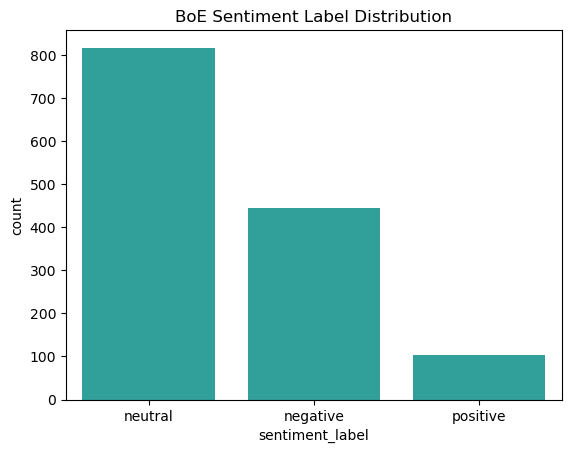

In [77]:
# Check sentiment distribution
print(boesl_data['sentiment_label'].value_counts(normalize=True))

sns.countplot(data=boesl_data, x='sentiment_label', color='lightseagreen')
plt.title('BoE Sentiment Label Distribution')
plt.show()

In [78]:
boesl_data['sentiment_ratio'].describe()

count    1365.000000
mean       -0.148110
std         0.287653
min        -1.000000
25%        -0.355263
50%        -0.184906
75%         0.011765
max         0.882353
Name: sentiment_ratio, dtype: float64

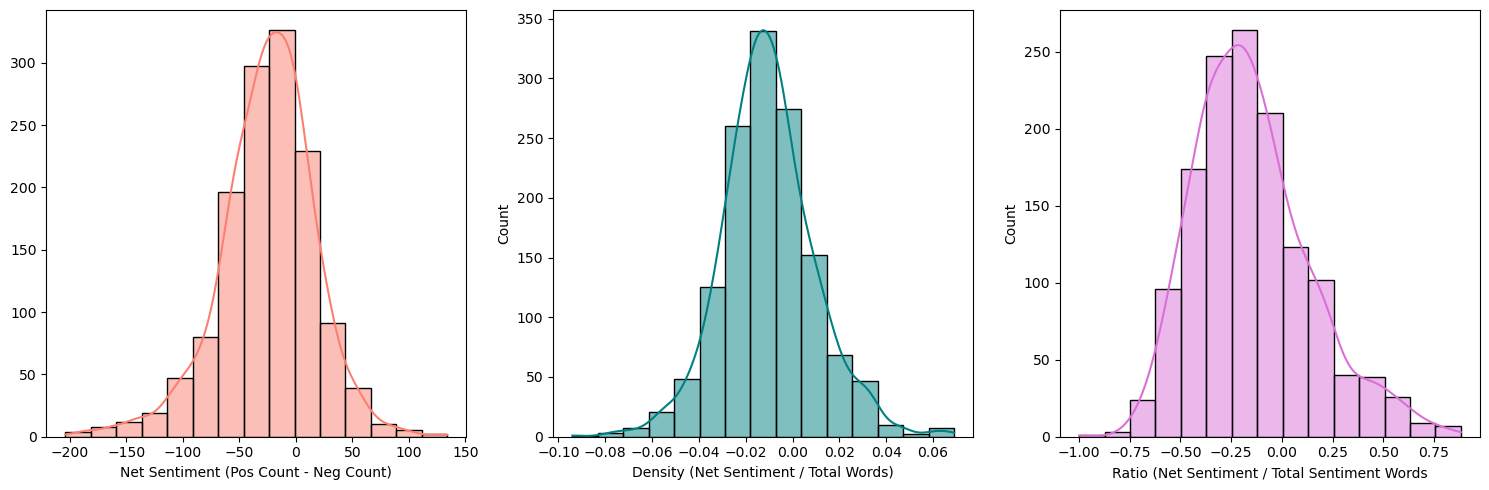

In [81]:
# View the three scoring options
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(data=boesl_data, x='net_sentiment', color='salmon', kde=True, bins=15)
plt.xlabel('Net Sentiment (Pos Count - Neg Count)')
plt.ylabel(None)

plt.subplot(1,3,2)
sns.histplot(data=boesl_data, x='sentiment_density', color='teal', kde=True, bins=15)
plt.xlabel('Density (Net Sentiment / Total Words)')

plt.subplot(1,3,3)
sns.histplot(data=boesl_data, x='sentiment_ratio', color='orchid', kde=True, bins=15)
plt.xlabel('Ratio (Net Sentiment / Total Sentiment Words')

plt.tight_layout()
plt.show()

### Net sentiment Moving average

In [84]:
# Set rolling average
monthly_net_sentiment = boesl_data['net_sentiment'].resample('ME').mean().dropna()
ns_rolling_avg = monthly_net_sentiment.rolling(window=6, min_periods=6).mean()

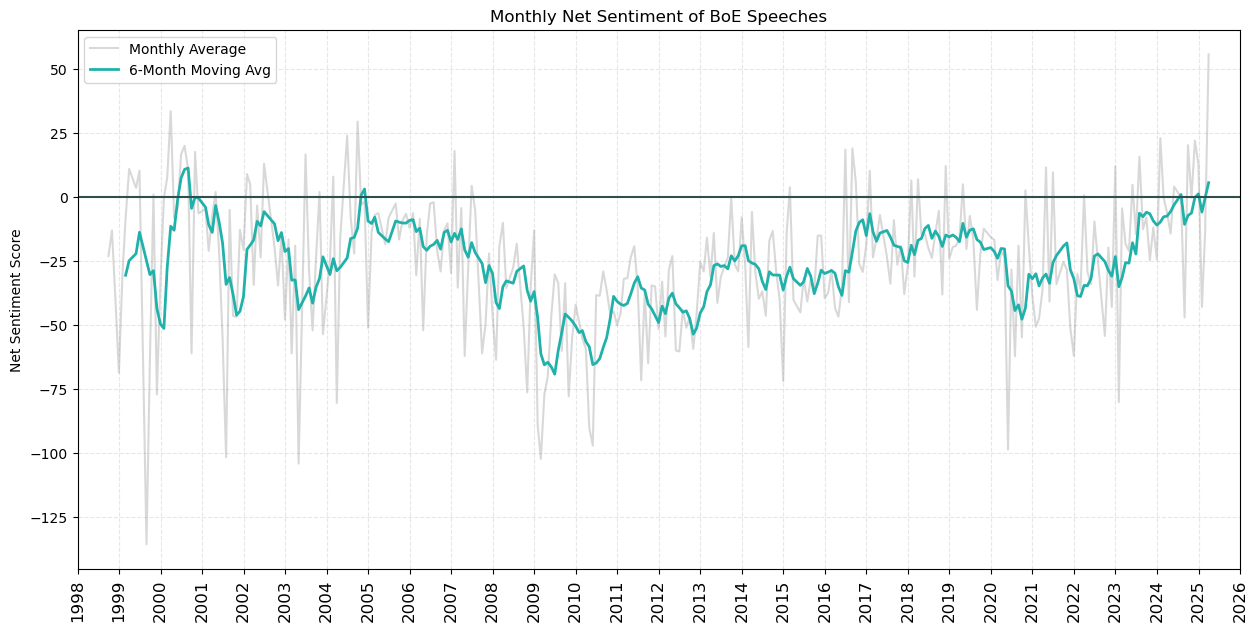

In [86]:
plt.figure(figsize=(15,7))
ax = plt.subplot()

plt.plot(monthly_net_sentiment, label='Monthly Average', alpha=0.3, color='grey')
plt.plot(ns_rolling_avg, label='6-Month Moving Avg', linewidth=2, color='lightseagreen')

# Add line at 0
plt.axhline(y=0, color='darkslategrey')

plt.title('Monthly Net Sentiment of BoE Speeches')
plt.ylabel('Net Sentiment Score')
plt.grid(True, linestyle='--', alpha=0.3)

year_format(monthly_net_sentiment)

plt.legend()
plt.show()

### Sentiment Density Over time

In [89]:
# Set rolling average
monthly_sentiment_density = boesl_data['sentiment_density'].resample('ME').mean().dropna()
sd_rolling_avg = monthly_sentiment_density.rolling(window=6, min_periods=6).mean()

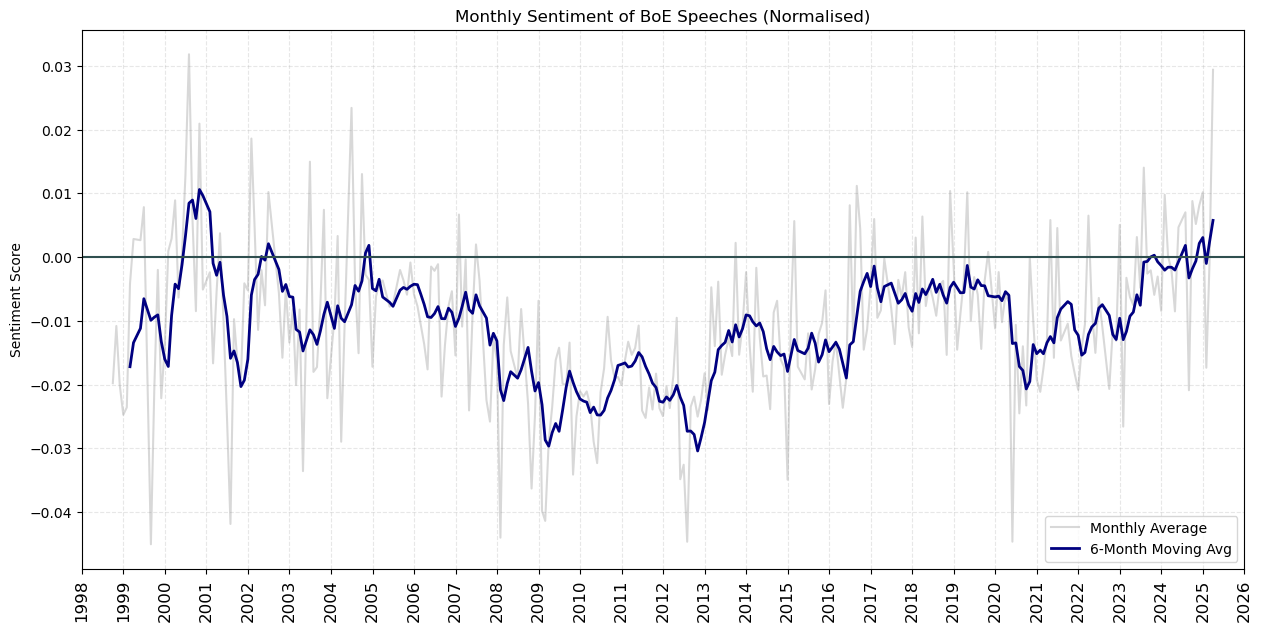

In [91]:
plt.figure(figsize=(15,7))
ax = plt.subplot()

plt.plot(monthly_sentiment_density, label='Monthly Average', alpha=0.3, color='grey')
plt.plot(sd_rolling_avg, label='6-Month Moving Avg', linewidth=2, color='navy')

# Add line at 0
plt.axhline(y=0, color='darkslategrey')

plt.title('Monthly Sentiment of BoE Speeches (Normalised)')
plt.ylabel('Sentiment Score')
gridlines()

year_format(monthly_sentiment_density)

plt.legend()
plt.show()

### Sentiment Ratio Over time

In [96]:
# Set rolling average
monthly_sentiment_ratio = boesl_data['sentiment_ratio'].resample('ME').mean().dropna()
rat_rolling_avg = monthly_sentiment_ratio.rolling(window=6, min_periods=6).mean()

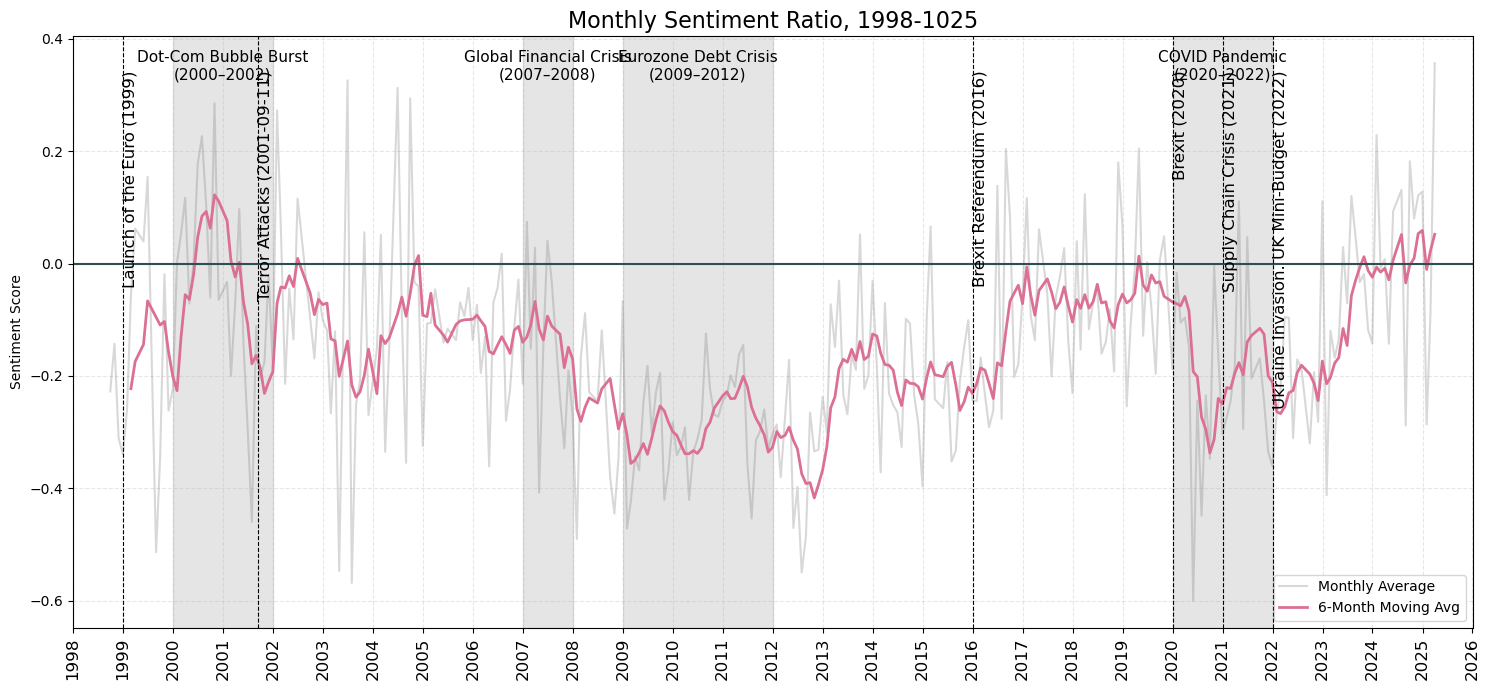

In [98]:
plt.figure(figsize=(15,7))

plt.plot(monthly_sentiment_ratio, label='Monthly Average', alpha=0.3, color='grey')
plt.plot(rat_rolling_avg, label='6-Month Moving Avg', linewidth=2, color='palevioletred')

# Add line at 0
plt.axhline(y=0, color='darkslategrey')

plt.title('Monthly Sentiment Ratio, 1998-1025', fontsize=16)
plt.ylabel('Sentiment Score')
milestones(label_position=0.95)
gridlines()

year_format(monthly_sentiment_density)

plt.legend()
plt.tight_layout()
plt.show()

**Observation:** Accepted LM sentiment scoring methods result in the same patterns, but become more normalised each time.

### Some options for scoring other sentiment words
- Density (litigious / length) * 1000
- Sentiment word proportion (litigious / sum of all sentiment words)
- Composite (e.g. caution score = uncertainty + constraining)

In [100]:
# Testing options for uncertainty score
# boesl_data['uncertainty_score'] = boesl_data['n_uncertainty'] / boesl_data['length'] * 1000
boesl_data['uncertainty_score'] = np.log1p((boesl_data['n_uncertainty'] / boesl_data['length']) * 1000) # with log scaling

<Axes: xlabel='uncertainty_score', ylabel='Count'>

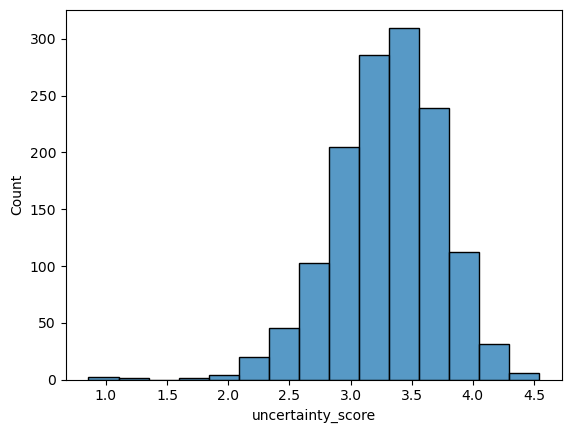

In [102]:
# Plot uncertainty score
sns.histplot(data=boesl_data, x='uncertainty_score', bins=15)

In [104]:
# Set rolling average
monthly_uncertainty_score = boesl_data['uncertainty_score'].resample('ME').mean().dropna()
un_rolling_avg = monthly_uncertainty_score.rolling(window=6, min_periods=6).mean()

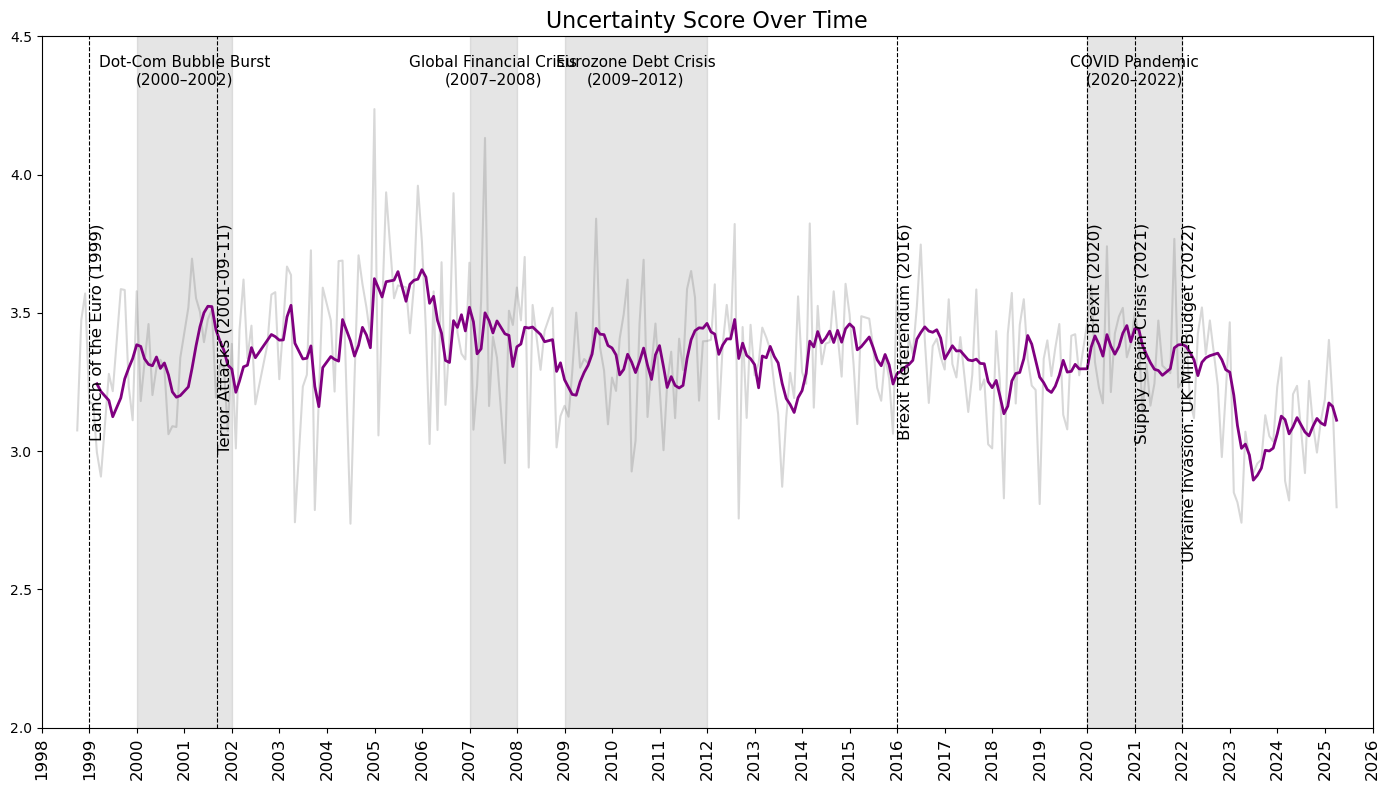

In [106]:
plt.figure(figsize=(14, 8))
ax = plt.subplot()

plt.plot(monthly_uncertainty_score, label='Monthly Average', alpha=0.3, color='grey')
plt.plot(un_rolling_avg, label='6-Month Moving Avg', linewidth=2, color='purple')

# Add line at 0
plt.axhline(y=0, color='darkslategrey')

year_format(monthly_uncertainty_score)
plt.ylim(2,4.5)
milestones(label_position=0.95)
plt.title('Uncertainty Score Over Time', fontsize=16)
plt.tight_layout()
plt.show()

In [112]:
# Create df for export
boesl_for_export = boesl_data[['custom_ref', 'title', 'author', 'is_gov',
       'text', 'sentiment_ratio',
       'sentiment_label', 'uncertainty_score']]

In [114]:
boesl_for_export.to_csv('uk_speeches_with_lm_scores.csv')

In [116]:
boesl_for_export.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1365 entries, 1998-09-15 to 2025-03-25
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   custom_ref         1365 non-null   object 
 1   title              1365 non-null   object 
 2   author             1365 non-null   object 
 3   is_gov             1365 non-null   float64
 4   text               1365 non-null   object 
 5   sentiment_ratio    1365 non-null   float64
 6   sentiment_label    1365 non-null   object 
 7   uncertainty_score  1365 non-null   float64
dtypes: float64(3), object(5)
memory usage: 96.0+ KB


# FinBERT

The below is adapted from code from the following sources:
- https://github.com/Vincent-Codes-Finance/sentiment/blob/main/sentiment.ipynb
- https://github.com/yukit-k/centralbank_analysis/blob/master/src/1_FOMC_Analysis_Preliminary.ipynb

## Apply to data

In [576]:
# Copy df
fbert_data = uk_data.copy()

In [144]:
''' Recommended to do only minimal cleaning for BERT as per the following discussions:
https://discuss.huggingface.co/t/how-much-cleaning-for-transformers/852/2
https://stackoverflow.com/questions/70649831/does-bert-model-need-text '''

# Simple clean function
def simple_clean(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\s+', ' ', text)  # Collapse extra whitespace
    return text.strip()

In [582]:
fbert_data['fbert_clean'] = fbert_data['text'].apply(simple_clean)
fbert_data.head(2)

custom_ref     reference country              title  \
date                                                                        
1998-09-15  UK_1998-09-15_George  r980915a_BOE      UK             Speech   
1998-10-21  UK_1998-10-21_George  r981021b_BOE      UK  Britain in Europe   

                   author  is_gov  \
date                                
1998-09-15  Edward George     1.0   
1998-10-21  Edward George     1.0   

                                                         text  \
date                                                            
1998-09-15  Thank you, Chairman. I'm actually very pleased...   
1998-10-21  It's a great pleasure to be here in the beauti...   

                                                   clean_text  \
date                                                            
1998-09-15  thank chairman actually pleased opportunity re...   
1998-10-21  great pleasure beautiful city bruges honoured ...   

                                                       tokens  length  \
date                                                                    
1998-09-15  [thank, chairman, actually, pleased, opportuni...    1162   
1998-10-21  [great, pleasure, beautiful, city, bruges, hon...    2108   

                                                  fbert_clean  
date                                                           
1998-09-15  Thank you, Chairman. I am actually very please...  
1998-10-21  It is a great pleasure to be here in the beaut...

In [584]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [585]:
def finbert_sentiment(text: str) -> tuple[float, float, float, str]:
    with torch.no_grad():
        inputs = tokenizer(
            text, return_tensors="pt", padding=True, truncation=True, max_length=512
        )
        outputs = model(**inputs)
        logits = outputs.logits
        scores = {
            k: v
            for k, v in zip(
                model.config.id2label.values(),
                scipy.special.softmax(logits.numpy().squeeze()),
            )
        }
        return (
            scores["positive"],
            scores["negative"],
            scores["neutral"],
            max(scores, key=scores.get),
        )

In [588]:
# Run on speech text
fbert_data[['finbert_pos', 'finbert_neg', "finbert_neu", "finbert_sentiment"]] = (
    fbert_data['fbert_clean'].apply(finbert_sentiment).apply(pd.Series)
)
fbert_data["finbert_score"] = fbert_data["finbert_pos"] - fbert_data["finbert_neg"]

# Add confidence score
fbert_data['finbert_confidence'] = fbert_data[['finbert_pos', 'finbert_neg', 'finbert_neu']].max(axis=1)

In [590]:
fbert_data.sample(3)

custom_ref     reference country  \
date                                                        
2008-07-14  UK_2008-07-14_jenkinson  r080714a_BOE      UK   
2019-02-14    UK_2019-02-14_vlieghe  r190214a_BOE      UK   
2010-04-27    UK_2010-04-27_haldane  r100427a_BOE      UK   

                                                        title     author  \
date                                                                       
2008-07-14         Financial Innovation: What Have We Learnt?  jenkinson   
2019-02-14  The economic outlook: Fading global tailwinds,...    vlieghe   
2010-04-27                          The $100 Billion Question    haldane   

            is_gov                                               text  \
date                                                                    
2008-07-14     0.0  At last year's conference, we presented a pape...   
2019-02-14     0.0  We are in a period of unusual uncertainty arou...   
2010-04-27     0.0  The car industry is a pollutant. Exhaust fumes...   

                                                   clean_text  \
date                                                            
2008-07-14  last year conference presented paper highlight...   
2019-02-14  period unusual uncertainty around economic out...   
2010-04-27  car industry pollutant exhaust fumes noxious p...   

                                                       tokens  length  \
date                                                                    
2008-07-14  [last, year, conference, presented, paper, hig...    2946   
2019-02-14  [period, unusual, uncertainty, around, economi...    2373   
2010-04-27  [car, industry, pollutant, exhaust, fumes, nox...    3109   

                                                  fbert_clean  finbert_pos  \
date                                                                         
2008-07-14  At last year's conference, we presented a pape...     0.339221   
2019-02-14  We are in a period of unusual uncertainty arou...     0.077398   
2010-04-27  The car industry is a pollutant. Exhaust fumes...     0.031036   

            finbert_neg  finbert_neu finbert_sentiment  finbert_score  \
date                                                                    
2008-07-14     0.019856     0.640923           neutral       0.319366   
2019-02-14     0.120208     0.802394           neutral      -0.042810   
2010-04-27     0.066431     0.902533           neutral      -0.035395   

            finbert_confidence  
date                            
2008-07-14            0.640923  
2019-02-14            0.802394  
2010-04-27            0.902533

In [592]:
# Save for reloading as pickle
fbert_data.to_pickle('fbert_pickle.pkl')

In [643]:
# Save to csv
fbert_for_export = fbert_data.drop(['country', 'clean_text', 'tokens', 'length', 'fbert_clean'], 
                                   axis=1)

fbert_for_export.to_csv('uk_speeches_with_finbert_scores_v2.csv')

In [118]:
# Read back in
fbert_data = pd.read_pickle('fbert_pickle.pkl')

## Explore results

### Overall net sentiment

In [122]:
# Check FinBERT confidence metrics
fbert_data['finbert_score'].describe()

count    1365.000000
mean       -0.057237
std         0.344910
min        -0.963808
25%        -0.152263
50%         0.019230
75%         0.114064
max         0.917439
Name: finbert_score, dtype: float64

finbert_sentiment
neutral     0.770696
negative    0.171429
positive    0.057875
Name: proportion, dtype: float64


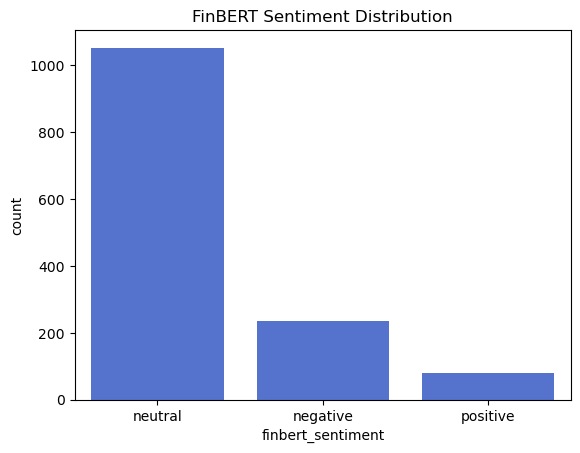

In [124]:
# Check sentiment distribution
print(fbert_data['finbert_sentiment'].value_counts(normalize=True))

sns.countplot(data=fbert_data, x='finbert_sentiment', color='royalblue')
plt.title('FinBERT Sentiment Distribution')
plt.show()

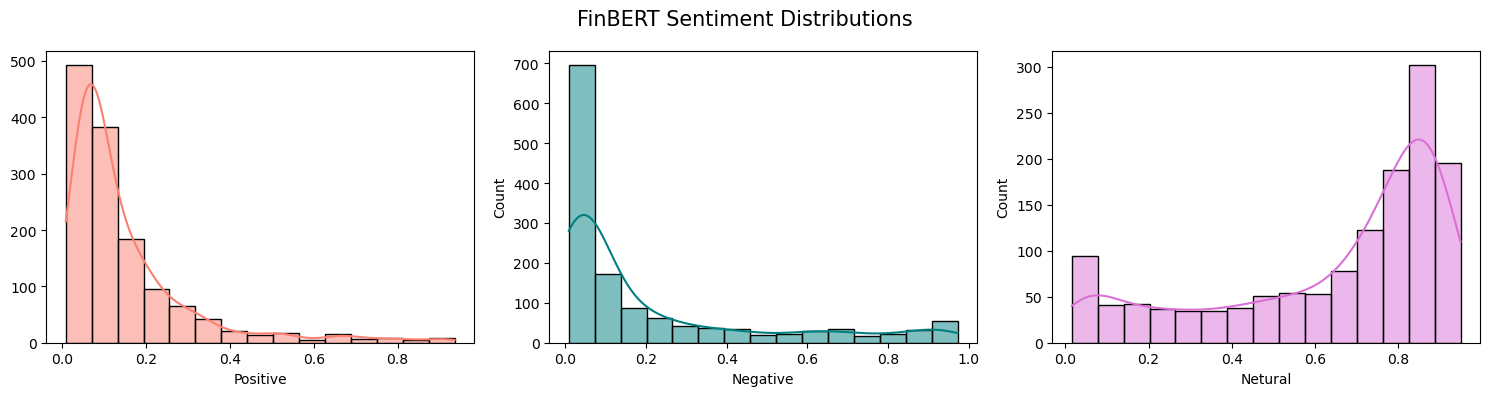

In [126]:
# View pos/neg/neutral histograms
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.histplot(data=fbert_data, x='finbert_pos', kde=True, color='salmon', bins=15)
plt.xlabel('Positive')
plt.ylabel(None)

plt.subplot(1,3,2)
sns.histplot(data=fbert_data, x='finbert_neg', kde=True, color='teal', bins=15)
plt.xlabel('Negative')

plt.subplot(1,3,3)
sns.histplot(data=fbert_data, x='finbert_neu', kde=True, color='orchid', bins=15)
plt.xlabel('Netural')

plt.suptitle('FinBERT Sentiment Distributions', fontsize=15)

plt.tight_layout()
plt.show()

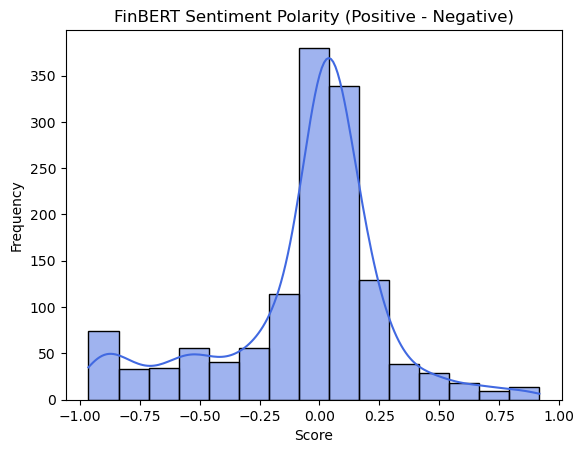

In [128]:
# View polarity
sns.histplot(fbert_data['finbert_score'], kde=True, bins=15, color='royalblue')
plt.title('FinBERT Sentiment Polarity (Positive - Negative)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

### FinBERT sentiment over time

In [131]:
# Set rolling average
monthly_fbert_sentiment = fbert_data['finbert_score'].resample('ME').mean().dropna()
fb_rolling_avg = monthly_fbert_sentiment.rolling(window=6, min_periods=6).mean()

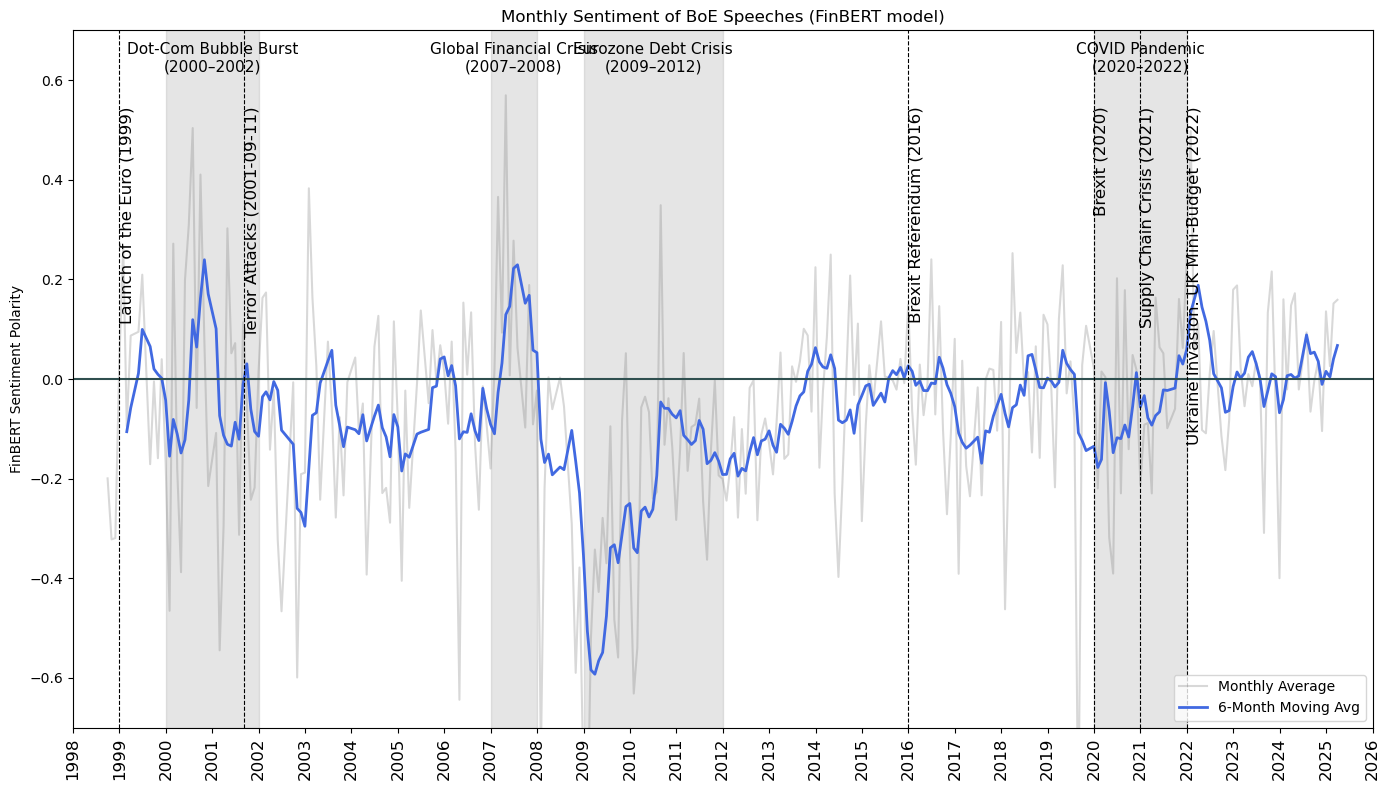

In [133]:
plt.figure(figsize=(14, 8))

plt.plot(monthly_fbert_sentiment, label='Monthly Average', alpha=0.3, color='grey')
plt.plot(fb_rolling_avg, label='6-Month Moving Avg', linewidth=2, color='royalblue')

# Add line at 0
plt.axhline(y=0, color='darkslategrey')

# Formatting
plt.title('Monthly Sentiment of BoE Speeches (FinBERT model)')
plt.ylabel('FinBERT Sentiment Polarity')
# gridlines()
year_format(monthly_fbert_sentiment)
milestones(label_position=1)
plt.ylim(-0.7, 0.7)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [135]:
# Quarterly sentiment
qe_fbert_sentiment = fbert_data['finbert_score'].resample('QE').mean().dropna()
qe_rolling = qe_fbert_sentiment.rolling(window=2, min_periods=1).mean()

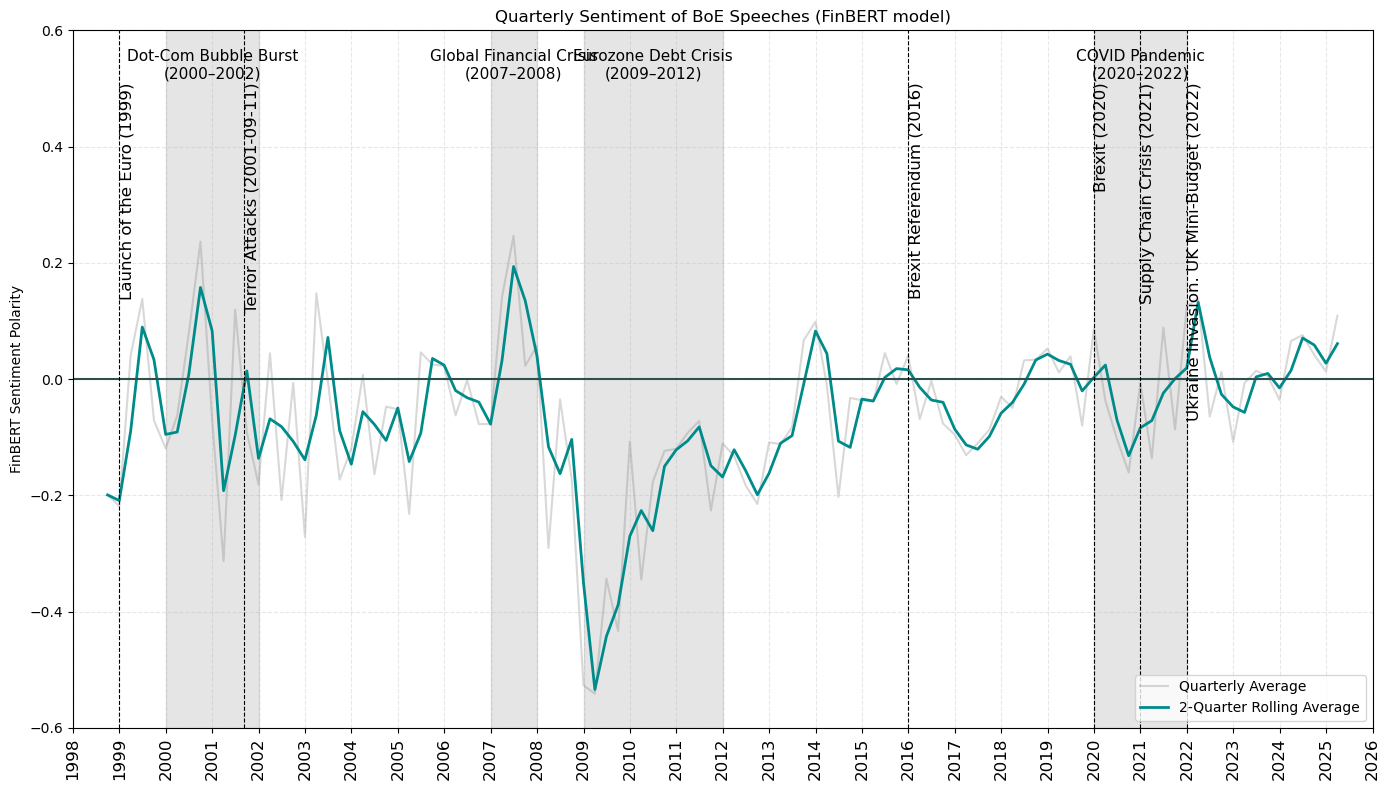

In [137]:
plt.figure(figsize=(14, 8))

plt.plot(qe_fbert_sentiment, label='Quarterly Average', alpha=0.3, color='grey')
plt.plot(qe_rolling, label='2-Quarter Rolling Average', linewidth=2, color='darkcyan')

# Add line at 0
plt.axhline(y=0, color='darkslategrey')

# Formatting
plt.title('Quarterly Sentiment of BoE Speeches (FinBERT model)')
plt.ylabel('FinBERT Sentiment Polarity')
gridlines()
year_format(qe_fbert_sentiment)
plt.ylim(-.6, .6)
milestones(label_position=0.95)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# FinBERT applied to individual sentences

In [140]:
# Copy df
fb_data_sentence = uk_data.copy()

In [146]:
# Clean text
fb_data_sentence['fbert_clean'] = fb_data_sentence['text'].apply(simple_clean)

In [166]:
# Split into sentences, analyse each, return average composite score
def analyse_text(text):
    # Split text into sentences
    sentences = sent_tokenize(text)
    
    # Initialize lists to store results
    sentence_data = []
    sentiment_scores = []
    
    # Process each sentence
    for sentence in sentences:
        if not sentence.strip():
            continue
            
        # Get sentiment
        pos, neg, neu, label = finbert_sentiment(sentence)
        
        # Calculate simple sentiment score (-1 to 1)
        sentiment_score = pos - neg
        sentiment_scores.append(sentiment_score)
        
        # Store sentence data
        sentence_data.append({
            'sentence': sentence,
            'positive': pos,
            'negative': neg,
            'neutral': neu,
            'label': label,
            'sentiment_score': sentiment_score
        })
    
    # Calculate composite score (simple average)
    composite_score = np.mean(sentiment_scores) if sentiment_scores else 0.0
    
    return {
        'sentence_data': sentence_data,
        'composite_score': composite_score
    }

In [182]:
# Apply analyse_text function to each sentence in the DataFrame
fb_data_sentence['sentiment_score'] = fb_data_sentence['fbert_clean'].apply(lambda text: analyse_text(text)['composite_score'] if pd.notna(text) and text.strip() != '' else np.nan)

In [183]:
# Function to get the most common label across all sentences
def get_overall_label(text):
    if pd.isna(text) or text.strip() == '':
        return np.nan
    
    results = analyse_text(text)
    sentences = results['sentence_data']
    if not sentences:
        return np.nan
    
    # Get all the labels from the sentences
    labels = [s['label'] for s in sentences]
    
    # Count the frequency of each label
    from collections import Counter
    label_counts = Counter(labels)
    
    # Return the most common label
    return label_counts.most_common(1)[0][0]

In [228]:
# Set rolling average for FinBERT sentence data
fbert_sentence_monthly = fb_data_sentence['sentiment_score'].resample('ME').mean()
fbert_sentence_monthly = fbert_sentence_monthly.dropna()
fb2_rolling_avg = fbert_sentence_monthly.rolling(window=6, min_periods=6).mean()

# Central Bank RoBERTa

### Load data - pivoted file

In [232]:
# Load file
# https://drive.google.com/file/d/169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9/view?usp=drive_link
# agent_sentiment_pivot.csv
file_id = '169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9'
# Create the direct download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the file locally
output_path = 'agent_sentiment_pivot_local.csv' 
gdown.download(download_url, output_path, quiet=False)
# Read the downloaded file 
agent_sentiment_pivot = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9
To: C:\Users\katej\Desktop\LSE Data Analytics\4. Employer Project\BoE-Beacon\agent_sentiment_pivot_local.csv
100%|██████████| 30.9M/30.9M [00:01<00:00, 22.7MB/s]


In [233]:
agent_sentiment_pivot.info()
agent_sentiment_pivot.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   custom_ref               1365 non-null   object 
 1   date                     1365 non-null   object 
 2   author                   1365 non-null   object 
 3   is_gov                   1365 non-null   int64  
 4   central_bank             1365 non-null   float64
 5   financial_sector         1365 non-null   float64
 6   firms                    1365 non-null   float64
 7   government               1365 non-null   float64
 8   households               1365 non-null   float64
 9   cbroberta_avg_score      1365 non-null   float64
 10  cbroberta_avg_sentiment  1365 non-null   int64  
 11  text                     1365 non-null   object 
dtypes: float64(6), int64(2), object(4)
memory usage: 128.1+ KB


custom_ref        date         author  is_gov  central_bank  \
0   UK_1998-09-15_George  1998-09-15  Edward George       1     -0.409745   
1   UK_1998-10-21_George  1998-10-21  Edward George       1     -0.134019   
2     UK_1998-10-21_King  1998-10-21    Mervyn King       0     -0.516879   
3     UK_1998-11-01_budd  1998-11-01           budd       0     -0.497668   
4  UK_1998-11-01_vickers  1998-11-01        vickers       0     -0.555400   

   financial_sector     firms  government  households  cbroberta_avg_score  \
0         -0.661564 -0.202167   -0.518037   -0.042013            -0.295018   
1          0.047685 -0.305432   -0.251951   -0.535169            -0.128637   
2         -0.644094 -0.581463   -0.580222   -0.672911            -0.601670   
3         -0.373081 -0.598642   -0.567226   -0.360106            -0.476216   
4         -0.629627 -0.683497   -0.339261   -0.289324            -0.569214   

   cbroberta_avg_sentiment                                               text  
0                        0  Thank you, Chairman. I'm actually very pleased...  
1                        0  It's a great pleasure to be here in the beauti...  
2                        0  Few industries have suffered more from volatil...  
3                        0  My topic this evening is the use of forecasts ...  
4                        0  Six years ago this week, sterling left the exc...

In [234]:
# Convert to datetime
agent_sentiment_pivot['date'] = pd.to_datetime(agent_sentiment_pivot['date'])

In [235]:
# Set date as index
agent_sentiment_pivot = agent_sentiment_pivot.set_index('date')

In [236]:
agent_sentiment_pivot.head(2)

custom_ref         author  is_gov  central_bank  \
date                                                                    
1998-09-15  UK_1998-09-15_George  Edward George       1     -0.409745   
1998-10-21  UK_1998-10-21_George  Edward George       1     -0.134019   

            financial_sector     firms  government  households  \
date                                                             
1998-09-15         -0.661564 -0.202167   -0.518037   -0.042013   
1998-10-21          0.047685 -0.305432   -0.251951   -0.535169   

            cbroberta_avg_score  cbroberta_avg_sentiment  \
date                                                       
1998-09-15            -0.295018                        0   
1998-10-21            -0.128637                        0   

                                                         text  
date                                                           
1998-09-15  Thank you, Chairman. I'm actually very pleased...  
1998-10-21  It's a great pleasure to be here in the beauti...

### Load data - unpivoted file

In [238]:
# https://drive.google.com/file/d/1gMUL1qvXJdT2OAbuvw_oZkd6a2K9VWPs/view?usp=drive_link
# agent_sentiment
file_id = '1gMUL1qvXJdT2OAbuvw_oZkd6a2K9VWPs'
# Create the direct download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the file locally
output_path = 'agent_sentiment_local.csv' 
gdown.download(download_url, output_path, quiet=False)
# Read the downloaded file 
agent_sentiment = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=1gMUL1qvXJdT2OAbuvw_oZkd6a2K9VWPs
To: C:\Users\katej\Desktop\LSE Data Analytics\4. Employer Project\BoE-Beacon\agent_sentiment_local.csv
100%|██████████| 16.6M/16.6M [00:00<00:00, 17.8MB/s]


In [244]:
# Rename values in agent column
mapper = {'firms': 'Firms', 
         'households': 'Households',
         'financial_sector': 'Financial Sector',
         'central_bank': 'Central Bank',
         'government' : 'Government'}

agent_sentiment['cbroberta_agent'] = agent_sentiment['cbroberta_agent'].map(mapper)

## Plot CB RoBERTa 

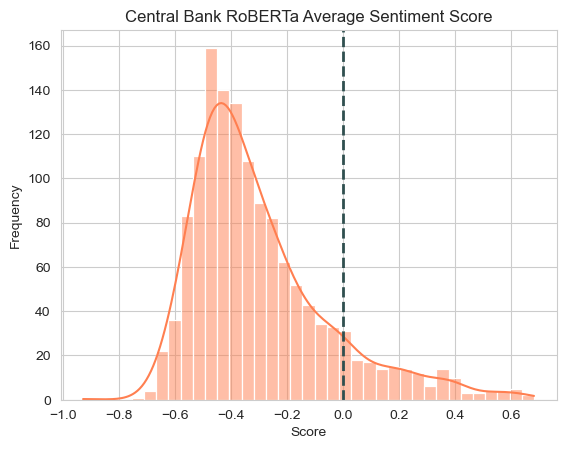

In [248]:
# Plot scores as histogram
sns.histplot(agent_sentiment_pivot['cbroberta_avg_score'], kde=True, bins=37, color='coral')
plt.title('Central Bank RoBERTa Average Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='darkslategrey', linestyle='--', linewidth=2)
plt.show()

**Observation:** CB Roberta skews negative compared to the other models.

### Over time

In [250]:
# Set rolling average
cbr_monthly_sentiment = agent_sentiment_pivot['cbroberta_avg_score'].resample('ME').mean().dropna()
cbr_rolling_avg = cbr_monthly_sentiment.rolling(window=6, min_periods=6).mean()

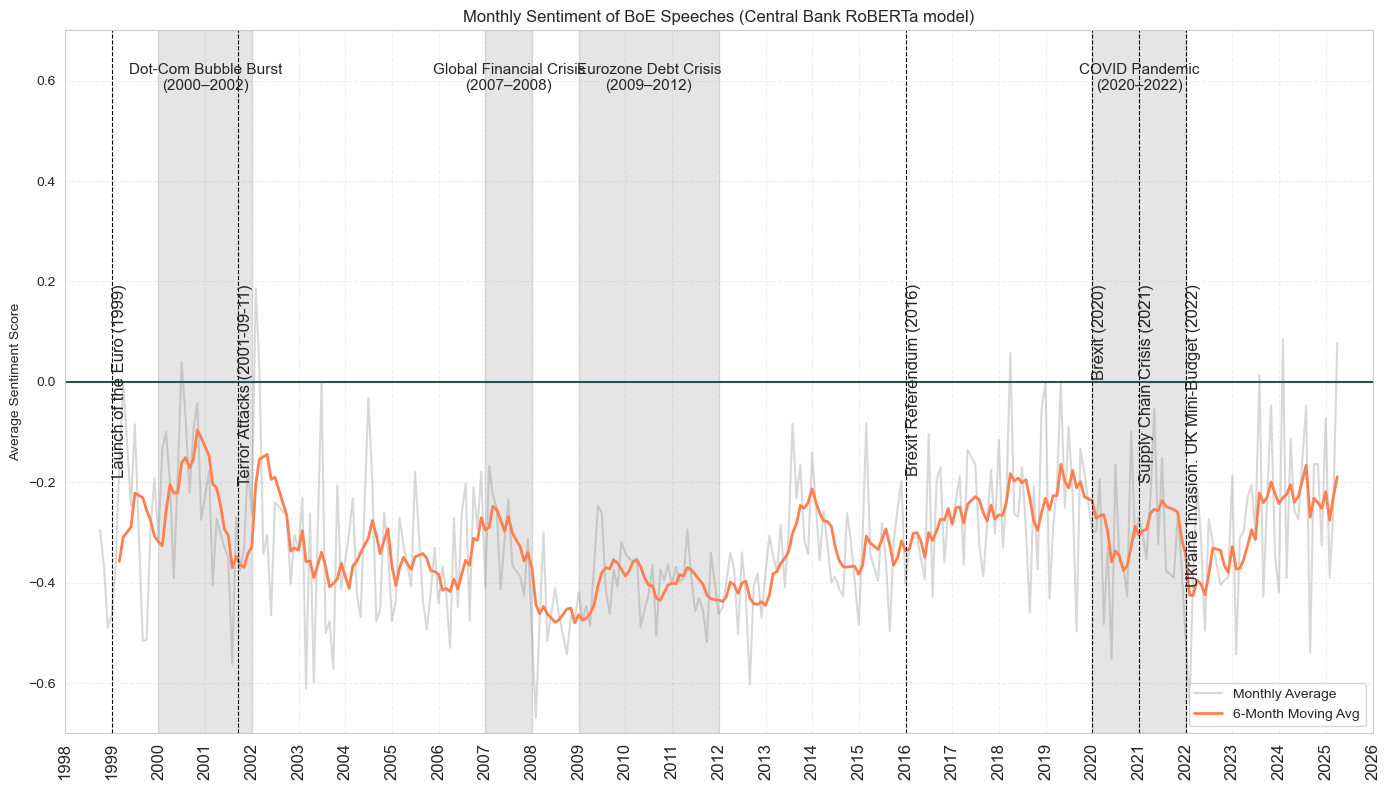

In [252]:
plt.figure(figsize=(14, 8))

plt.plot(cbr_monthly_sentiment, label='Monthly Average', alpha=0.3, color='grey')
plt.plot(cbr_rolling_avg, label='6-Month Moving Avg', linewidth=2, color='coral')

# Add line at 0
plt.axhline(y=0, color='darkslategrey')

# Formatting
plt.title('Monthly Sentiment of BoE Speeches (Central Bank RoBERTa model)')
plt.ylabel('Average Sentiment Score')
gridlines()
year_format(cbr_monthly_sentiment)
milestones(label_position=1.4)
plt.ylim(-0.7, 0.7)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Agent frequency

#### Overall

In [254]:
# Group by count of agent
agent_freq = agent_sentiment.groupby('cbroberta_agent').size().sort_values(ascending=False).reset_index()

# Rename cols
cols = ['cbroberta_agent', 'count']
agent_freq.columns = cols

# Calc percentages
total = agent_freq['count'].sum()
agent_freq['rel_freq'] = agent_freq['count'] / total *100

agent_freq

cbroberta_agent  count   rel_freq
0  Financial Sector  84780  39.979817
1      Central Bank  48912  23.065497
2             Firms  37089  17.490109
3        Households  31146  14.687560
4        Government  10130   4.777018

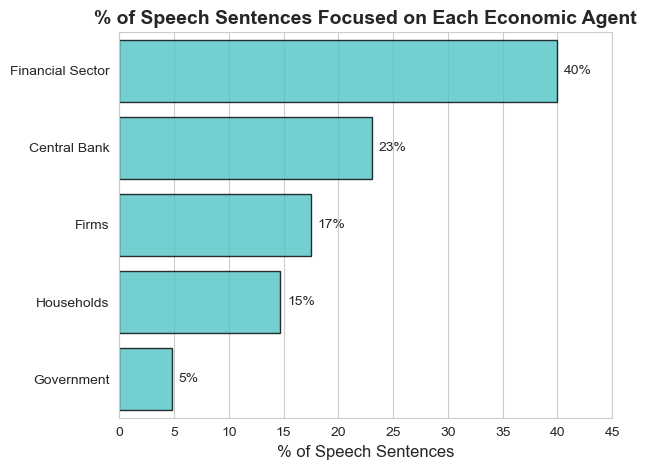

In [256]:
sns.set_style('whitegrid')
ax = sns.barplot(
    data=agent_freq, 
    y='cbroberta_agent', 
    x='rel_freq',
    color='#3CD7D9',
    alpha=0.8,              
    edgecolor='black',      
    linewidth=1)             

plt.ylabel(None)
plt.xlabel('% of Speech Sentences', fontsize=12)
plt.xlim(0,45)  # Set x limit
# plt.suptitle('Which Economic Agents are Discussed the Most?', weight='bold', fontsize=14)
plt.title('% of Speech Sentences Focused on Each Economic Agent', weight='bold', fontsize=14)

# Bar labels
bars = ax.containers[0]
ax.bar_label(bars, fmt='%.0f%%', padding=5)

plt.tight_layout()
plt.savefig('agent_freq.png', dpi=300)
plt.show()

#### Agent freq over time

In [258]:
# Group by count of agent
agent_freq_time = agent_sentiment.groupby(['cbroberta_agent', 'date']).size().reset_index()

# Convert to datetime
agent_freq_time['date'] = pd.to_datetime(agent_freq_time['date'])

# Rename columns
agent_freq_time.columns = ['cbroberta_agent', 'date', 'count']

# Calculate the total count for each date
date_totals = agent_freq_time.groupby('date')['count'].sum().reset_index()
date_totals.columns = ['date', 'date_total'] # Rename cols
agent_freq_time = agent_freq_time.merge(date_totals, on='date') # Merge in totals
agent_freq_time['relative_freq'] = agent_freq_time['count'] / agent_freq_time['date_total'] * 100

# Make date index 
agent_freq_time = agent_freq_time.set_index('date')

# agent_freq_time = agent_freq_time[agent_freq_time.index >= '2015-01-01']

agent_freq_time.head()

cbroberta_agent  count  date_total  relative_freq
date                                                        
1998-09-15    Central Bank     31          83      37.349398
1998-10-21    Central Bank     60         229      26.200873
1998-11-01    Central Bank    241         383      62.924282
1998-11-19    Central Bank     25          94      26.595745
1998-12-01    Central Bank     88         233      37.768240

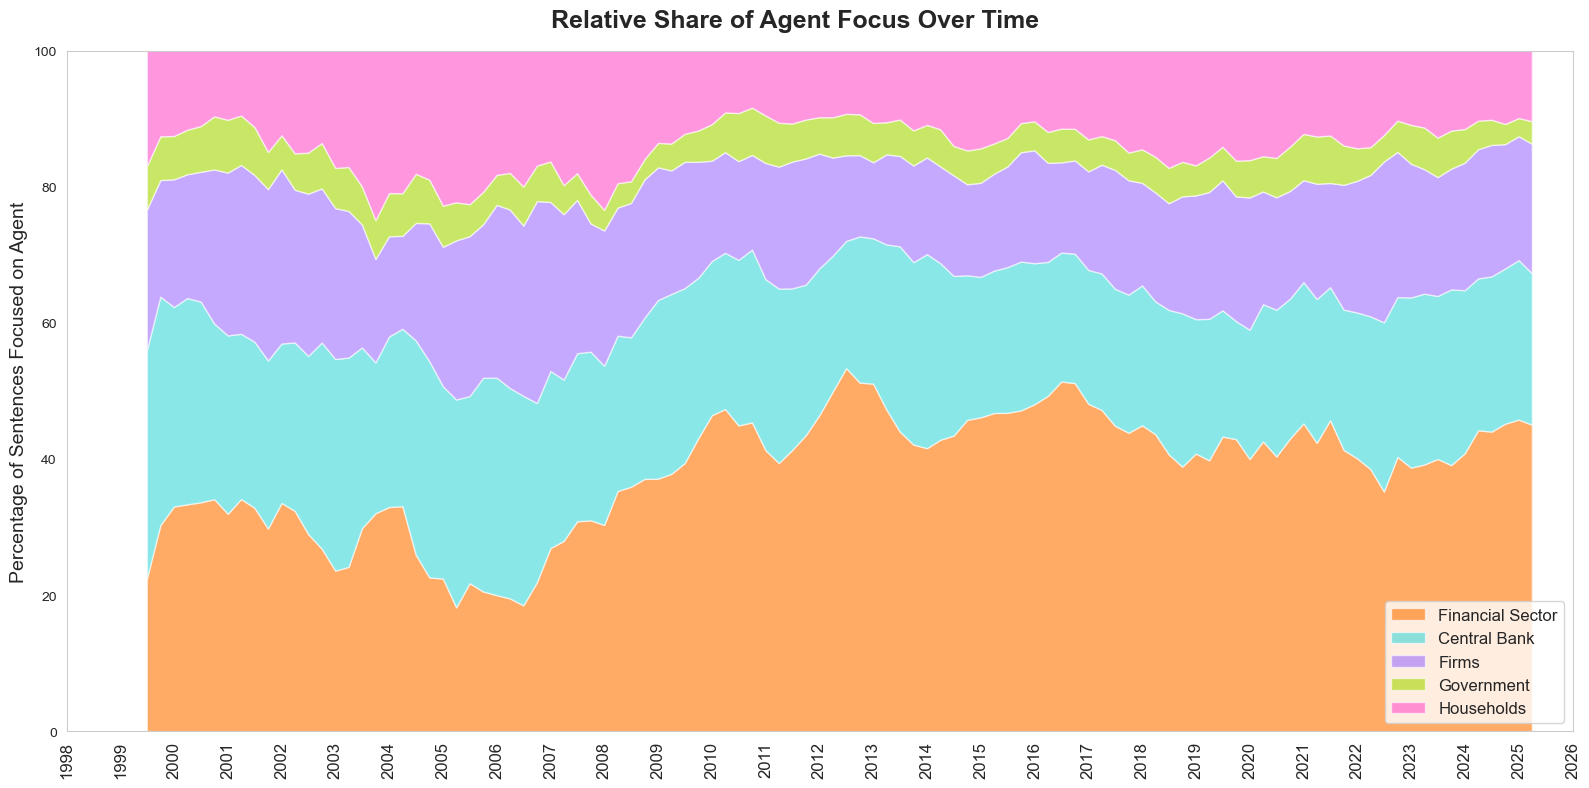

In [260]:
# Create dictionaries to store data
resample_data = {}
rolling_data = {}

# Define agents
agents = ['Central Bank', 'Financial Sector', 'Firms', 'Government', 'Households']

for agent in agents:
    # Filter the DataFrame for just this agent
    agent_filter = agent_freq_time[agent_freq_time['cbroberta_agent'] == agent]
    
    # Resample using relative_freq instead of count
    resample = agent_filter['relative_freq'].resample('QE').mean().dropna()
    
    # Calculate rolling average
    rolling = resample.rolling(window=4, min_periods=4).mean()
    
    # Store in dictionaries
    resample_data[agent] = resample
    rolling_data[agent] = rolling

# Create a DataFrame with all agents
stacked_data = pd.DataFrame()
for agent in agents:
    stacked_data[agent] = rolling_data[agent]

# Create plot
plt.figure(figsize=(16, 8))

plt.stackplot(stacked_data.index, 
              [stacked_data['Financial Sector'], 
               stacked_data['Central Bank'],
               stacked_data['Firms'],
               stacked_data['Government'],
               stacked_data['Households']],
              labels=['Financial Sector', 'Central Bank', 'Firms', 'Government', 'Households'],
              colors=['#FF7300', '#3CD7D9', '#9E71FE', '#A5D700', '#FF50C8'],
              alpha=0.6)

# Formatting
plt.suptitle('Relative Share of Agent Focus Over Time', fontsize=18, weight='bold')
plt.ylabel('Percentage of Sentences Focused on Agent', fontsize=14)
year_format(agent_freq_time)
# milestones(label_position=.95)
plt.ylim(0, 100) 
plt.legend(loc='lower right', prop={'size':12})
plt.grid(False)

plt.tight_layout()
plt.show()

**Observation:** Financial Sector became much more of a focus after the 2008 economic crash.

### Avg sentiment by agent

#### Overall 

In [262]:
# Group by average score per agent
agent_avg = agent_sentiment.groupby('cbroberta_agent')['cbroberta_score'].mean().sort_values(ascending=False).copy().reset_index()
agent_avg

cbroberta_agent  cbroberta_score
0             Firms        -0.215290
1        Households        -0.343731
2  Financial Sector        -0.357462
3      Central Bank        -0.365737
4        Government        -0.372643

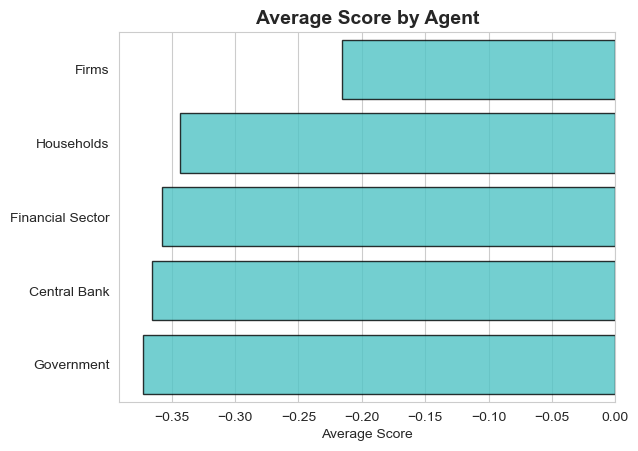

In [264]:
sns.set_style('whitegrid')
sns.barplot(
    data=agent_avg, 
    y='cbroberta_agent', 
    x='cbroberta_score',
    color='#3CD7D9',
    alpha=0.8,              
    edgecolor='black',      
    linewidth=1)             

plt.ylabel(None)
plt.xlabel('Average Score')
plt.title('Average Score by Agent', weight='bold', fontsize=14)

# plt.savefig('avg_score_agent.png', dpi=300, bbox_inches='tight')
plt.show()

#### Sentiment by Frequency

In [266]:
# Merge frequency and sentiment onto one df
agent_freq_sentiment = agent_avg.merge(agent_freq, on='cbroberta_agent').drop('rel_freq', axis=1)
agent_freq_sentiment

cbroberta_agent  cbroberta_score  count
0             Firms        -0.215290  37089
1        Households        -0.343731  31146
2  Financial Sector        -0.357462  84780
3      Central Bank        -0.365737  48912
4        Government        -0.372643  10130

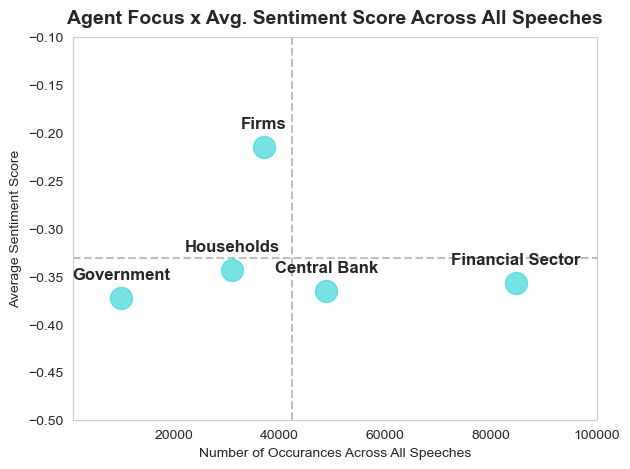

In [268]:
plt.scatter(agent_freq_sentiment['count'],
            agent_freq_sentiment['cbroberta_score'],
            s=250,
            c='#3CD7D9',
            alpha=0.7,)

# Add name labels with a slight offset
for i, label in enumerate(agent_freq_sentiment['cbroberta_agent']):
    x = agent_freq_sentiment['count'].iloc[i]
    y = agent_freq_sentiment['cbroberta_score'].iloc[i]
    
    # Offset
    plt.text(x, y + 0.02, label, ha='center', fontsize=12, weight='bold')

# Calculate average values
avg_count = np.mean(agent_freq_sentiment['count'])
avg_score = np.mean(agent_freq_sentiment['cbroberta_score'])
# Add average lines
plt.axhline(y=avg_score, color='gray', linestyle='--', alpha=0.5, label=f'Avg Score: {avg_score:.2f}')
plt.axvline(x=avg_count, color='gray', linestyle='--', alpha=0.5, label=f'Avg Count: {avg_count:.0f}')

plt.ylim(-0.5, -0.1)
plt.xlim(1000, 100000)
plt.grid(False)

# Titles 
plt.title('Agent Focus x Avg. Sentiment Score Across All Speeches', weight='bold', size=14, pad=10)
plt.ylabel('Average Sentiment Score')
plt.xlabel('Number of Occurances Across All Speeches')

plt.tight_layout()
plt.savefig('agent_scatter.png', dpi=300)
plt.show()

**Observation:** Firms show notably higher sentiment than the other agents, on average.

#### Sentiment by agent over time

##### **All time**

In [271]:
agent_sentiment['cbroberta_agent'].value_counts()

cbroberta_agent
Financial Sector    84780
Central Bank        48912
Firms               37089
Households          31146
Government          10130
Name: count, dtype: int64

In [273]:
# Aggregate by agent and date
agent_sentiment_agg = agent_sentiment.groupby(['cbroberta_agent', 'date'])[['cbroberta_score']].mean().reset_index()

# Convert to datetime
agent_sentiment_agg['date'] = pd.to_datetime(agent_sentiment_agg['date'])

# Make date index 
agent_sentiment_agg = agent_sentiment_agg.set_index('date')

agent_sentiment_agg

cbroberta_agent  cbroberta_score
date                                       
1998-09-15    Central Bank        -0.409745
1998-10-21    Central Bank        -0.255258
1998-11-01    Central Bank        -0.523060
1998-11-19    Central Bank        -0.464046
1998-12-01    Central Bank        -0.578633
...                    ...              ...
2025-02-28      Households        -0.436912
2025-03-03      Households         0.269962
2025-03-06      Households        -0.682128
2025-03-24      Households        -0.030078
2025-03-25      Households         0.668340

[6019 rows x 2 columns]

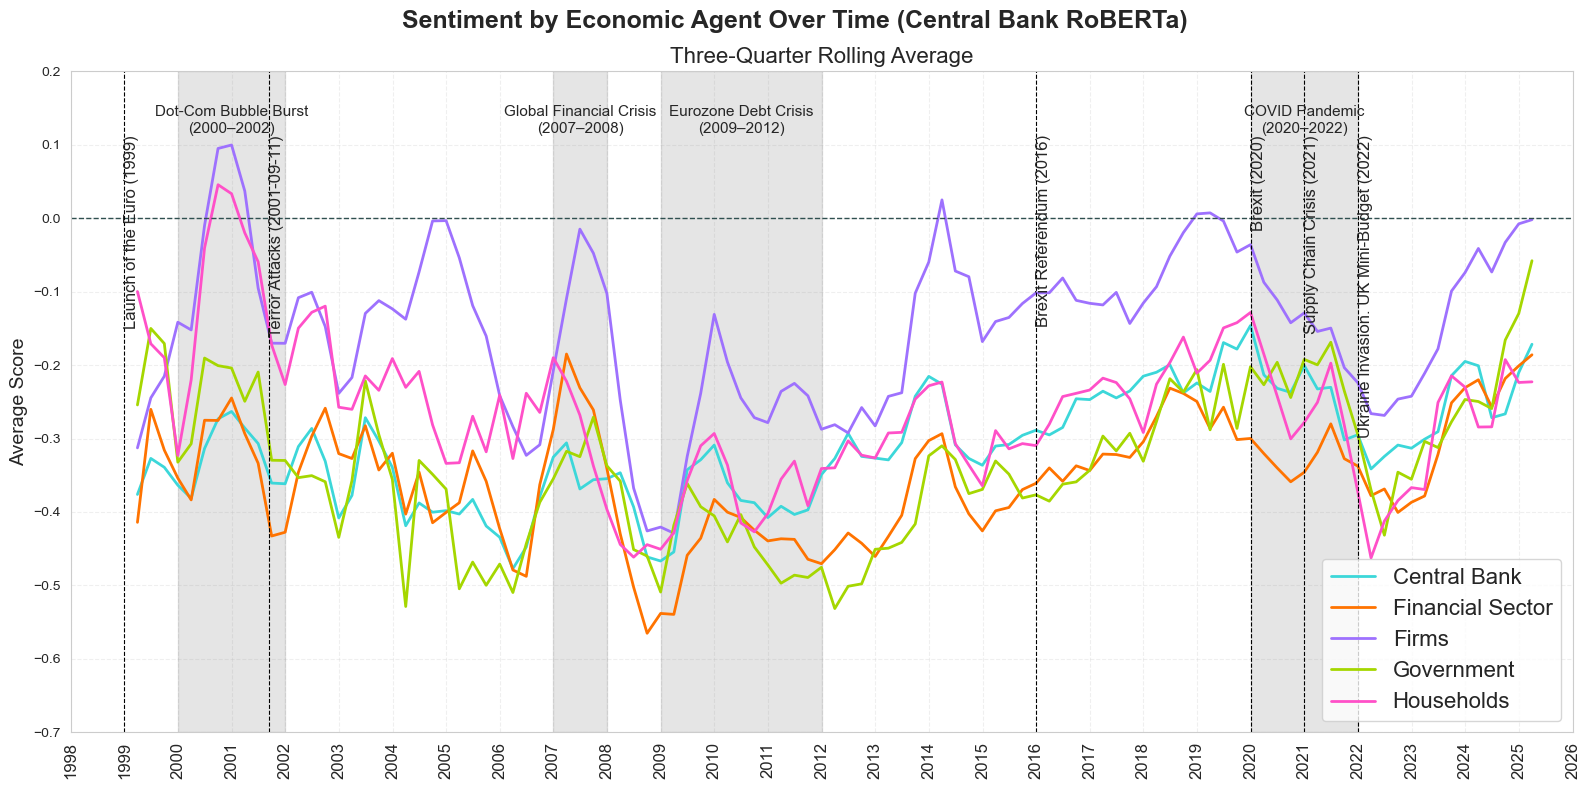

In [275]:
# Create dictionaries to store data
resample_data = {}
rolling_data = {}

# Define agent
agents = ['Central Bank', 'Financial Sector', 'Firms', 'Government', 'Households']

for agent in agents:
    # Filter the DataFrame for just this agent
    agent_filter = agent_sentiment_agg[agent_sentiment_agg['cbroberta_agent'] == agent]
    
    # Resample
    resample = agent_filter['cbroberta_score'].resample('QE').mean().dropna()
    
    # Calculate rolling average
    rolling = resample.rolling(window=3, min_periods=3).mean()
    
    # Store in dictionaries
    resample_data[agent] = resample
    rolling_data[agent] = rolling

# Create plot
plt.figure(figsize=(16, 8))

# Plot each agent
plt.plot(rolling_data['Central Bank'], label='Central Bank', linewidth=2, color='#3CD7D9')
plt.plot(rolling_data['Financial Sector'], label='Financial Sector', linewidth=2, color='#FF7300')
plt.plot(rolling_data['Firms'], label='Firms', linewidth=2, color='#9E71FE')
plt.plot(rolling_data['Government'], label='Government', linewidth=2, color='#A5D700')
plt.plot(rolling_data['Households'], label='Households', linewidth=2, color='#FF50C8')

# Add line at 0
plt.axhline(y=0, color='darkslategrey', linestyle='--', linewidth=1)

# Formatting
plt.suptitle('Sentiment by Economic Agent Over Time (Central Bank RoBERTa)', fontsize=18, weight='bold')
plt.title('Three-Quarter Rolling Average', fontsize=16)
plt.ylabel('Average Score', fontsize=14)
gridlines()
year_format(agent_sentiment_agg)
milestones(label_position=1)
plt.ylim(-0.7, 0.2)
plt.legend(loc='lower right', prop={'size':16})

plt.tight_layout()
# plt.savefig('agents_over_time.png', dpi=300)
plt.show()

##### **Past 10 years only**

In [277]:
agent_sentiment_agg_pten = agent_sentiment_agg[agent_sentiment_agg.index >= '2015-01-01']
agent_sentiment_agg_pten.head()

cbroberta_agent  cbroberta_score
date                                       
2015-01-20    Central Bank        -0.085677
2015-01-22    Central Bank        -0.492185
2015-01-23    Central Bank        -0.023284
2015-01-26    Central Bank        -0.653483
2015-01-28    Central Bank        -0.364266

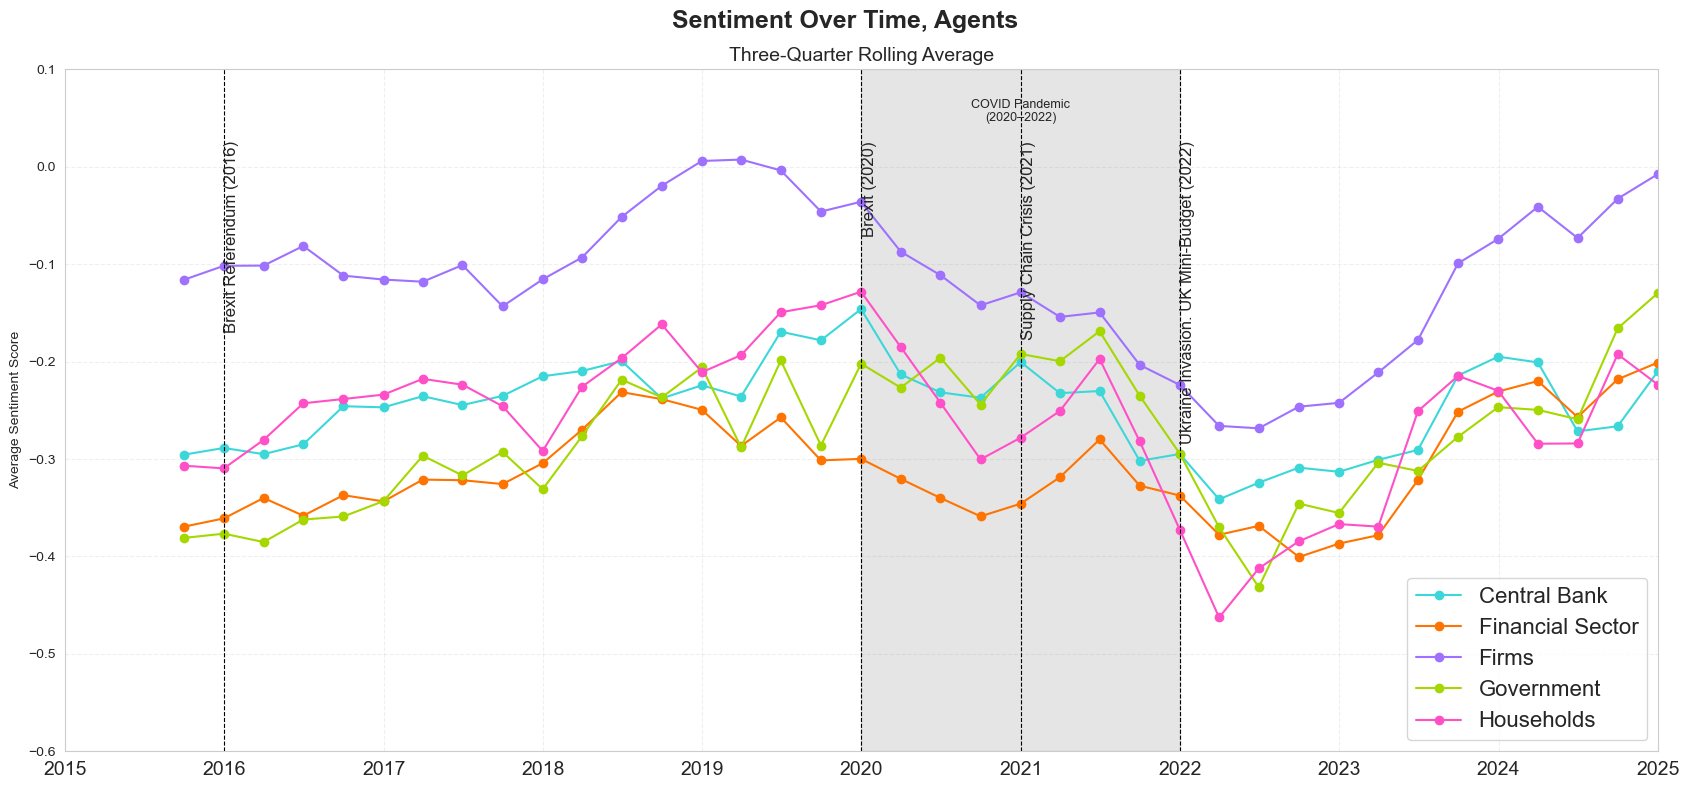

In [279]:
# Create dictionaries to store data
resample_data = {}
rolling_data = {}

# Define agent
agents = ['Central Bank', 'Financial Sector', 'Firms', 'Government', 'Households']

for agent in agents:
    # Filter the DataFrame for just this agent
    agent_filter = agent_sentiment_agg_pten[agent_sentiment_agg_pten['cbroberta_agent'] == agent]
    
    # Resample
    resample = agent_filter['cbroberta_score'].resample('QE').mean().dropna()
    
    # Calculate rolling average
    rolling = resample.rolling(window=3, min_periods=3).mean()
    
    # Store in dictionaries
    resample_data[agent] = resample
    rolling_data[agent] = rolling

# Create plot
plt.figure(figsize=(17, 8))

# Plot each agent
plt.plot(rolling_data['Central Bank'], label='Central Bank', linewidth=1.5, color='#3CD7D9', marker='o')
plt.plot(rolling_data['Financial Sector'], label='Financial Sector', linewidth=1.5, color='#FF7300', marker='o')
plt.plot(rolling_data['Firms'], label='Firms', linewidth=1.5, color='#9E71FE', marker='o')
plt.plot(rolling_data['Government'], label='Government', linewidth=1.5, color='#A5D700', marker='o')
plt.plot(rolling_data['Households'], label='Households', linewidth=1.5, color='#FF50C8', marker='o')

# Add line at 0
# plt.axhline(y=0, color='darkslategrey', linestyle='--', linewidth=1)

# Formatting
plt.suptitle('Sentiment Over Time, Agents', fontsize=18, weight='bold')
plt.title('Three-Quarter Rolling Average', fontsize=14)
plt.ylabel('Average Sentiment Score')
gridlines()
year_format_pten(agent_sentiment_agg_pten, fontsize=14)
milestones_pten(label_position=1.05)
plt.ylim(-0.6, 0.1)
plt.legend(loc='lower right', prop={'size':16})

plt.tight_layout()
plt.savefig('households_vs_firms.png', dpi=300)
plt.show()

**Observations:**
- Firms consistently more positive sentiment than other agents.
- Households appear the most volatile: they went from the highest sentiment outside firms in 2019 to the lowest in 2022.
- Sentiment about households also seem to sometimes lead sentiment shift around that time - looking at the same period, household sentiment dip is followed by financial sector and government; a year later, the inverse: household sentiment increases before these other agents. 

### CBR example 
Looking for an example of a single speech to use in our presentation

In [1396]:
# Find long speeches
uk_data[(uk_data['length'] > 3000) & (uk_data.index > '2016-01-01')]

custom_ref     reference country  \
date                                                      
2016-01-19   UK_2016-01-19_Carney  r160119a_BOE      UK   
2016-01-25   UK_2016-01-25_forbes  r160125a_BOE      UK   
2016-03-08    UK_2016-03-08_weale  r160308b_BOE      UK   
2016-05-18  UK_2016-05-18_haldane  r160518a_BOE      UK   
2016-05-19  UK_2016-05-19_vlieghe  r160519a_BOE      UK   
...                           ...           ...     ...   
2025-01-23  UK_2025-01-23_Wilkins           NaN      UK   
2025-02-12   UK_2025-02-12_Greene           NaN      UK   
2025-02-26  UK_2025-02-26_Dhingra           NaN      UK   
2025-02-28  UK_2025-02-28_Ramsden           NaN      UK   
2025-03-06     UK_2025-03-06_Mann           NaN      UK   

                                                        title  \
date                                                            
2016-01-19                               The turn of the year   
2016-01-25        A tale of two labour markets: the UK and US   
2016-03-08                     Unconventional monetary policy   
2016-05-18                                   The Great Divide   
2016-05-19  Monetary policy expectations and long term int...   
...                                                       ...   
2025-01-23  Geopolitics and financial stability: a plan be...   
2025-02-12  Not such an island after all ? speech by Megan...   
2025-02-26  Between a shock and a hard place: trade fragme...   
2025-02-28  Surveys, forecasts and scenarios: setting UK m...   
2025-03-06  Holding the anchor in turbulent waters  speec...   

                     author  is_gov  \
date                                  
2016-01-19      Mark Carney     1.0   
2016-01-25           forbes     0.0   
2016-03-08            weale     0.0   
2016-05-18          haldane     0.0   
2016-05-19          vlieghe     0.0   
...                     ...     ...   
2025-01-23  Carolyn Wilkins     0.0   
2025-02-12     Megan Greene     0.0   
2025-02-26    Swati Dhingra     0.0   
2025-02-28     Dave Ramsden     0.0   
2025-03-06          L. Mann     0.0   

                                                         text  \
date                                                            
2016-01-19  It is a pleasure to be at Queen Mary Universit...   
2016-01-25  Thanks to Dan Wales and Ida Hjortsoe for playi...   
2016-03-08  Thank you for inviting me here today. I would ...   
2016-05-18  In November last year, the Bank of England hos...   
2016-05-19  My talk today is about long-term interest rate...   
...                                                       ...   
2025-01-23  Speech  Introduction  There is no better place...   
2025-02-12  Speech  We often say the UK is a small, open e...   
2025-02-26  Speech  I am delighted to deliver the Dow lect...   
2025-02-28  Speech  Thank you for the invitation to speak ...   
2025-03-06  Speech  Introduction  It is particularly fitti...   

                                                   clean_text  \
date                                                            
2016-01-19  pleasure queen mary university london give 201...   
2016-01-25  thanks dan wales ida hjortsoe playing key role...   
2016-03-08  thank inviting today would like talk unconvent...   
2016-05-18  november last year bank england hosted called ...   
2016-05-19  talk today long term interest rates long term ...   
...                                                       ...   
2025-01-23  speech introduction better place speak geopoli...   
2025-02-12  speech often say uk small open economy therefo...   
2025-02-26  speech delighted deliver dow lecture last time...   
2025-02-28  speech thank invitation speak stellenbosch uni...   
2025-03-06  speech introduction particularly fitting discu...   

                                                       tokens  length  
date                                                                   
2016-01-19  [pleasure, queen, mary, university, london, gi...    

In [103]:
# Pull individual speech - have tried a few to see which is best for plotting
agent_sentiment_pivot[agent_sentiment_pivot['custom_ref'] == 'UK_2024-09-20_Mann']
# agent_sentiment_pivot[agent_sentiment_pivot['custom_ref'] == 'UK_2025-02-28_Ramsden']
# agent_sentiment_pivot[agent_sentiment_pivot['custom_ref'] == 'UK_2025-02-26_Dhingra']
# agent_sentiment_pivot[agent_sentiment_pivot['custom_ref'] == 'UK_2025-01-23_Wilkins']
# agent_sentiment_pivot[agent_sentiment_pivot['custom_ref'] == 'UK_2025-02-12_Greene']

custom_ref            author  is_gov  central_bank  \
date                                                                     
2024-09-20  UK_2024-09-20_Mann  Catherine L Mann       0     -0.596972   

            financial_sector     firms  government  households  \
date                                                             
2024-09-20         -0.671272 -0.540808   -0.540158   -0.724159   

            cbroberta_avg_score  cbroberta_avg_sentiment  \
date                                                       
2024-09-20            -0.619448                        0   

                                                         text  
date                                                           
2024-09-20  Bank of England Page 1 Policy spillovers when ...

In [105]:
# cbr_example = agent_sentiment[agent_sentiment['custom_ref'] == 'UK_2025-01-23_Wilkins']
cbr_example = agent_sentiment[agent_sentiment['custom_ref'] == 'UK_2024-09-20_Mann']
cbr_example = cbr_example.groupby('cbroberta_agent')['cbroberta_score']\
    .mean().sort_values(ascending=False).copy().reset_index()

cbr_example

cbroberta_agent  cbroberta_score
0        Government        -0.540158
1             Firms        -0.540808
2      Central Bank        -0.596972
3  Financial Sector        -0.671272
4        Households        -0.724159

In [107]:
# Group by count of agent
# cbr_example_size = agent_sentiment[agent_sentiment['custom_ref'] == 'UK_2025-01-23_Wilkins']
cbr_example_size = agent_sentiment[agent_sentiment['custom_ref'] == 'UK_2024-09-20_Mann']
cbr_example_size = cbr_example_size.groupby('cbroberta_agent').size().sort_values(ascending=False).reset_index()

cbr_example_size.columns = ['cbroberta_agent', 'frequency']

cbr_example_size

cbroberta_agent  frequency
0      Central Bank         67
1             Firms         55
2  Financial Sector         53
3        Households         34
4        Government          6

In [109]:
cbr_example_merge = cbr_example.merge(cbr_example_size, on='cbroberta_agent')
cbr_example_merge

cbroberta_agent  cbroberta_score  frequency
0        Government        -0.540158          6
1             Firms        -0.540808         55
2      Central Bank        -0.596972         67
3  Financial Sector        -0.671272         53
4        Households        -0.724159         34

In [117]:
# Calculate min/max values for axis limits
min_score = cbr_example_merge['cbroberta_score'].min()
max_score = cbr_example_merge['cbroberta_score'].max()
max_freq = cbr_example_merge['frequency'].max()

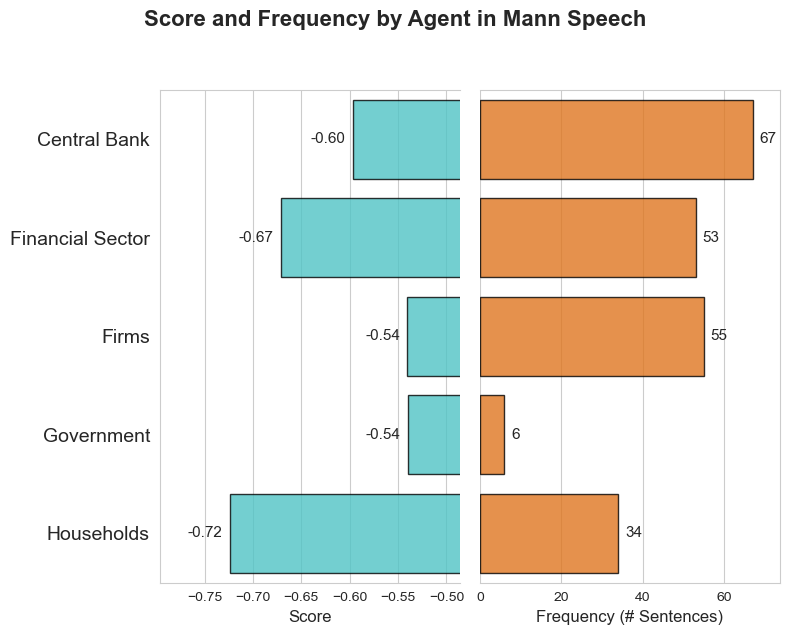

In [119]:
# Set style
sns.set_style('whitegrid')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharey=True, gridspec_kw={'width_ratios': [1, 1]})

# Sort data
cbr_example_merge = cbr_example_merge.sort_values('cbroberta_agent')

# Plot scores
score_bars = sns.barplot(
    data=cbr_example_merge, 
    y='cbroberta_agent', 
    x='cbroberta_score',
    color='#3CD7D9',
    alpha=0.8,              
    edgecolor='black',      
    linewidth=1,
    ax=ax1)

# Plot frequency
freq_bars = sns.barplot(
    data=cbr_example_merge, 
    y='cbroberta_agent', 
    x='frequency',
    color='#FF7300',
    alpha=0.8,              
    edgecolor='black',      
    linewidth=1,
    ax=ax2)

# Add bar labels
ax1.bar_label(ax1.containers[0], fmt='%.2f', padding=5, fontsize=11)
ax2.bar_label(ax2.containers[0], fmt='%d', padding=5, fontsize=11)

# Labels and formatting
ax1.set_ylabel(None)
ax2.set_ylabel(None) 
ax1.set_xlabel('Score', fontsize=12)
ax2.set_xlabel('Frequency (# Sentences)', fontsize=12)

# Add title spanning both subplots
plt.suptitle('Score and Frequency by Agent in Mann Speech', weight='bold', fontsize=16, y=1.05)

# Increase font size for agents 
ax1.tick_params(axis='y', labelsize=13)

# Invert x axis
ax1.invert_xaxis()

# Increase font size for y-tick labels
ax1.tick_params(axis='y', labelsize=14) 

# Add padding
ax1.set_xlim(min_score * 1.1, max_score * 0.9) 
ax2.set_xlim(0, max_freq * 1.1)                 

# Remove spine
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig('mann_speech_dual_axis.png', dpi=300, bbox_inches='tight')
plt.show()

### Exploration of top speeches by score

#### Text prep

In [895]:
agent_sentiment.shape

(212057, 7)

In [558]:
# Clean text
agent_sentiment_pivot['clean_text'] = agent_sentiment_pivot['text'].apply(preprocess_text)

In [560]:
# Tokenise text
agent_sentiment_pivot['tokens'] = agent_sentiment_pivot['clean_text'].apply(word_tokenize)

In [562]:
# Lemmatize text
agent_sentiment_pivot['lemm'] = agent_sentiment_pivot['tokens'].apply(lemmatize_tokens)

#### Pos/neg word clouds

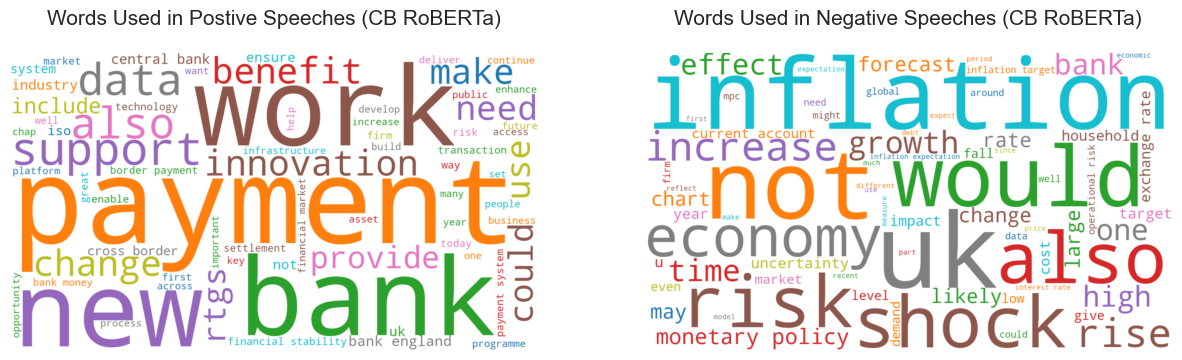

In [668]:
# Subset top 20 positive and negative speeches - average score
cb_pos_speech = agent_sentiment_pivot.nlargest(20, 'cbroberta_avg_score')
cb_neg_speech = agent_sentiment_pivot.nsmallest(20, 'cbroberta_avg_score')

# Unify all text by sentiment
cb_pos_top = ' '.join([' '.join(text) for text in cb_pos_speech['lemm']])
cb_neg_top = ' '.join([' '.join(text) for text in cb_neg_speech['lemm']])

# Add custom stopwords
c_stop = set([])


# Create a word cloud - pos
cb_pos_text_cloud = WordCloud(width=1600, height=900,
                           min_font_size=10,
                           max_words=70,
                           background_color='white',
                           stopwords=c_stop,
                           colormap='tab10').generate(cb_pos_top)

# Create a word cloud - neg
cb_neg_text_cloud = WordCloud(width=1600, height=900,
                           min_font_size=10,
                           max_words=70,
                           background_color='white',
                           stopwords=c_stop,
                           colormap='tab10').generate(cb_neg_top)

plt.figure(figsize=(15,7))

# Plot pos word cloud
plt.subplot(1,2,1)
plt.imshow(cb_pos_text_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words Used in Postive Speeches (CB RoBERTa)', fontsize=15, pad=20)

# Plot neg word cloud
plt.subplot(1,2,2)
plt.imshow(cb_neg_text_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words Used in Negative Speeches (CB RoBERTa)', fontsize=15, pad=20)
plt.show()

In [897]:
# Function to create word cloud of top 20 speeches by score in CB RoBERTa scores

def cb_wordcloud(df, target_col, name, lemm_col='lemm'):
                 
    # Subset top 20 positive speeches 
    speech = df.nlargest(20, target_col)

    # Unify all text 
    joined = ' '.join([' '.join(text) for text in speech[lemm_col]])

    # Add custom stopwords
    c_stop = set(['market', 'bank'])

    # Create a word cloud 
    text_cloud = WordCloud(width=1600, height=900,
                           min_font_size=10,
                           max_words=70,
                           background_color='white',
                           stopwords=c_stop,
                           colormap='tab10').generate(joined)

    plt.figure(figsize=(16,7))

    # Plot word cloud
    plt.subplot(1,2,1)
    plt.imshow(text_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Words Used in Positive {name} Speeches', fontsize=15, weight='bold', pad=20)

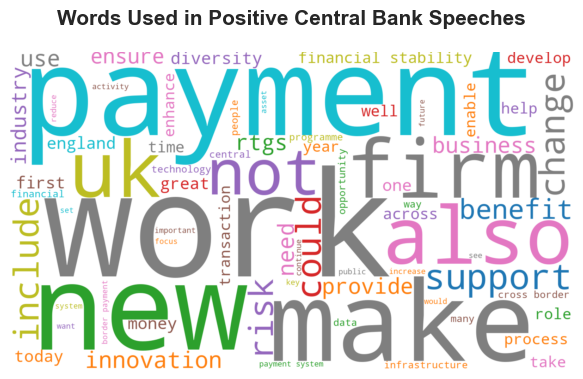

In [899]:
cb_wordcloud(df=agent_sentiment_pivot, target_col='central_bank', name='Central Bank')

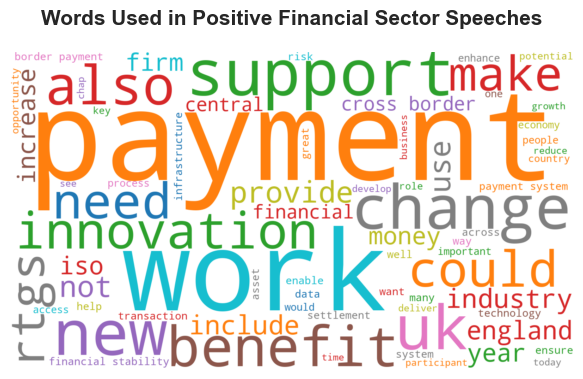

In [900]:
cb_wordcloud(df=agent_sentiment_pivot, target_col='financial_sector', name='Financial Sector')

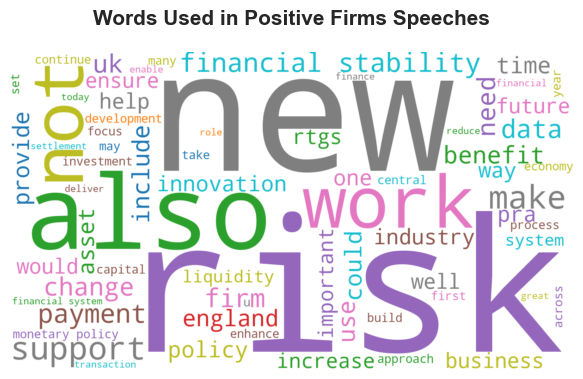

In [901]:
cb_wordcloud(df=agent_sentiment_pivot, target_col='firms', name='Firms')

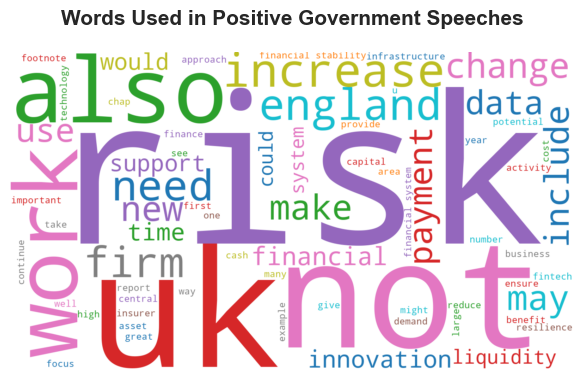

In [902]:
cb_wordcloud(df=agent_sentiment_pivot, target_col='government', name='Government')

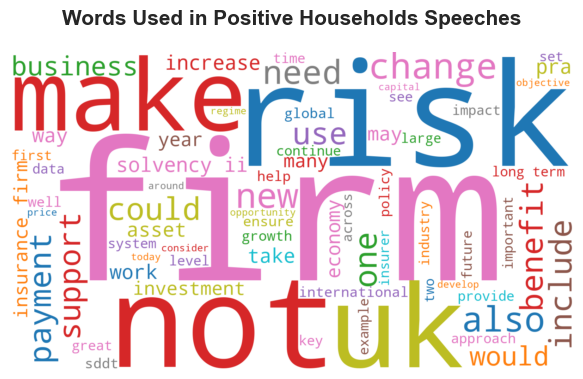

In [904]:
cb_wordcloud(df=agent_sentiment_pivot, target_col='households', name='Households')

# Chat GPT

### Run analysis

In [186]:
# Subset five years of data for test (due to cost of running this on Chat GPT)
past_five = uk_data[(uk_data.index >= '2017-01-01') & (uk_data.index <= '2024-12-31')]

print(past_five.shape)
past_five.tail()

(507, 10)


custom_ref reference country  \
date                                                  
2024-11-25  UK_2024-11-25_Dhingra       NaN      UK   
2024-12-02  UK_2024-12-02_Foulger       NaN      UK   
2024-12-03  UK_2024-12-03_Lintern       NaN      UK   
2024-12-09  UK_2024-12-09_Ramsden       NaN      UK   
2024-12-16  UK_2024-12-16_Cleland       NaN      UK   

                                                        title  \
date                                                            
2024-11-25       Inflation dynamics - slides by Swati Dhingra   
2024-12-02  The SWES: using system-wide scenario analysis ...   
2024-12-03  Once more unto the breach - speech by Philippe...   
2024-12-09  Getting the balance right: ensuring the Banks...   
2024-12-16  Payment cycles: An update on the Future Roadma...   

                      author  is_gov  \
date                                   
2024-11-25     Swati Dhingra     0.0   
2024-12-02       Lee Foulger     0.0   
2024-12-03  Philippe Lintern     0.0   
2024-12-09      Dave Ramsden     0.0   
2024-12-16  Victoria Cleland     0.0   

                                                         text  \
date                                                            
2024-11-25  Inflation Dynamics Bank of England Watchers Co...   
2024-12-02  Speech  Macroprudential policymakers have the ...   
2024-12-03  Speech  Introduction  Once more unto the brea...   
2024-12-09  Speech  Good afternoon, thank you to OMFIF for...   
2024-12-16  Speech  I am delighted to be addressing such a...   

                                                   clean_text  \
date                                                            
2024-11-25  inflation dynamics bank england watchers confe...   
2024-12-02  speech macroprudential policymakers primary ob...   
2024-12-03  speech introduction unto breach dear friends c...   
2024-12-09  speech good afternoon thank omfif invitation s...   
2024-12-16  speech delighted addressing diverse innovative...   

                                                       tokens  length  
date                                                                   
2024-11-25  [inflation, dynamics, bank, england, watchers,...     263  
2024-12-02  [speech, macroprudential, policymakers, primar...    2311  
2024-12-03  [speech, introduction, unto, breach, dear, fri...    1407  
2024-12-09  [speech, good, afternoon, thank, omfif, invita...    3159  
2024-12-16  [speech, delighted, addressing, diverse, innov...    1589

**Note:** API key removed below

In [500]:
# Set your API key
# client = openai.OpenAI(api_key='tk')

In [190]:
# Convert speeches to list
text_list = past_five['text'].dropna().tolist()

In [192]:
# Function to get continuous sentiment score
def get_continuous_sentiment(speech_text):
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",  
            messages=[
                {"role": "system", "content": "You are a helpful assistant that performs sentiment analysis on central-bank communications."},
                {"role": "user", "content": f"Analyse the overall sentiment of this Bank of England speech on a scale from -1.0 (very negative) to +1.0 (very positive), where 0 is neutral. Consider the tone and outlook expressed by the speaker. Respond with only a number between -1.0 and 1.0.\n\nSpeech: {speech_text}"}
            ],
            temperature=0.2,
            max_tokens=10  # Just need a decimal number
        )
        # Convert response to float and ensure it's in valid range
        score = float(response.choices[0].message.content.strip())
        return max(-1.0, min(1.0, score))  # Clamp to [-1, 1] range
    except Exception as e:
        print(f"Error processing text: {e}")
        return "Error"

In [194]:
# Process each speech
continuous_scores = []
for i, speech in enumerate(text_list):
    print(f"Processing speech {i+1}/{len(text_list)}")
    score = get_continuous_sentiment(speech)
    continuous_scores.append(score)
    time.sleep(1)  # Rate limit

Processing speech 1/507
Processing speech 2/507
Processing speech 3/507
Processing speech 4/507
Processing speech 5/507
Processing speech 6/507
Processing speech 7/507
Processing speech 8/507
Processing speech 9/507
Processing speech 10/507
Processing speech 11/507
Processing speech 12/507
Processing speech 13/507
Processing speech 14/507
Processing speech 15/507
Processing speech 16/507
Processing speech 17/507
Processing speech 18/507
Processing speech 19/507
Processing speech 20/507
Processing speech 21/507
Processing speech 22/507
Processing speech 23/507
Processing speech 24/507
Processing speech 25/507
Processing speech 26/507
Processing speech 27/507
Processing speech 28/507
Processing speech 29/507
Processing speech 30/507
Processing speech 31/507
Processing speech 32/507
Processing speech 33/507
Processing speech 34/507
Processing speech 35/507
Processing speech 36/507
Processing speech 37/507
Processing speech 38/507
Processing speech 39/507
Processing speech 40/507
Processin

In [210]:
# Create results dataframe
gpt_results = pd.DataFrame({
    'text': text_list, 
    'gpt_cont_score': continuous_scores
})

# Save results
results_df.to_csv("boe_continuous_sentiment_output.csv", index=False)

gpt_results

text  gpt_cont_score
0    Minouche Shafik, Bradley Speigner, and Arthur ...            -0.3
1    Good evening. It is a pleasure to be at the LS...             0.2
2    It is a pleasure to be here this evening. The ...             0.3
3    It is a pleasure to be at as part of this Bund...             0.5
4    It is a pleasure to be back in Leeds to give a...             0.5
..                                                 ...             ...
502  Inflation Dynamics Bank of England Watchers Co...            -0.4
503  Speech  Macroprudential policymakers have the ...             0.3
504  Speech  Introduction  Once more unto the brea...             0.3
505  Speech  Good afternoon, thank you to OMFIF for...             0.2
506  Speech  I am delighted to be addressing such a...             0.7

[507 rows x 2 columns]

### Merge with main df

In [220]:
# Reset index of past_five
past_five = past_five.reset_index()

In [227]:
# Merge Chat GPT and main data
gpt_data = past_five.merge(gpt_results, on='text')

# Set data as index
gpt_data = gpt_data.set_index('date')

print(gpt_data.shape)
gpt_data.head()

(507, 11)


custom_ref     reference country  \
date                                                       
2017-01-13  UK_2017-01-13_saunders  r170113a_BOE      UK   
2017-01-16    UK_2017-01-16_Carney  r170116a_BOE      UK   
2017-01-24    UK_2017-01-24_salmon  r170124a_BOE      UK   
2017-01-25    UK_2017-01-25_Carney  r170125a_BOE      UK   
2017-02-07    UK_2017-02-07_forbes  r170207a_BOE      UK   

                                   title       author  is_gov  \
date                                                            
2017-01-13             The labour market     saunders     0.0   
2017-01-16                        Lambda  Mark Carney     1.0   
2017-01-24            Market Functioning       salmon     0.0   
2017-01-25        The Promise of FinTech  Mark Carney     1.0   
2017-02-07  A MONIAC (not manic) Economy       forbes     0.0   

                                                         text  \
date                                                            
2017-01-13  Minouche Shafik, Bradley Speigner, and Arthur ...   
2017-01-16  Good evening. It is a pleasure to be at the LS...   
2017-01-24  It is a pleasure to be here this evening. The ...   
2017-01-25  It is a pleasure to be at as part of this Bund...   
2017-02-07  It is a pleasure to be back in Leeds to give a...   

                                                   clean_text  \
date                                                            
2017-01-13  minouche shafik bradley speigner arthur turrel...   
2017-01-16  good evening pleasure lse honour share podium ...   
2017-01-24  pleasure evening economic political events pas...   
2017-01-25  pleasure part bundesbank conference digitising...   
2017-02-07  pleasure back leeds give another briefing bank...   

                                                       tokens  length  \
date                                                                    
2017-01-13  [minouche, shafik, bradley, speigner, arthur, ...    2753   
2017-01-16  [good, evening, pleasure, lse, honour, share, ...    2959   
2017-01-24  [pleasure, evening, economic, political, event...    1733   
2017-01-25  [pleasure, part, bundesbank, conference, digit...    2171   
2017-02-07  [pleasure, back, leeds, give, another, briefin...    3058   

            gpt_cont_score  
date                        
2017-01-13            -0.3  
2017-01-16             0.2  
2017-01-24             0.3  
2017-01-25             0.5  
2017-02-07             0.5

In [787]:
# Save to csv
# chat_gpt_for_export = gpt_data[['custom_ref', 'gpt_cont_score']]
# chat_gpt_for_export.to_csv('chat_gpt_scores.csv', index=False)

### Plot

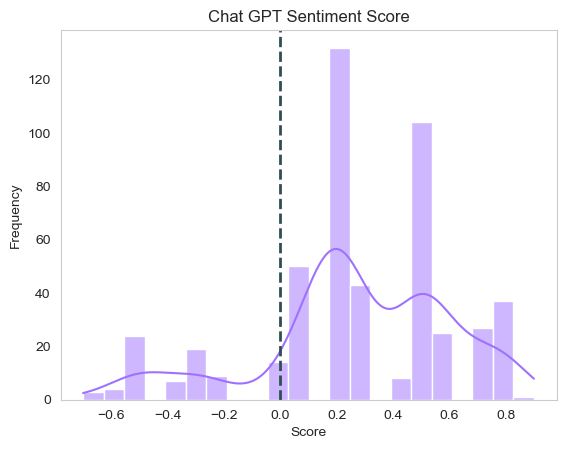

In [411]:
# Plot scores as histogram
sns.histplot(gpt_data['gpt_cont_score'], kde=True, bins=22, color='#9E71FE')
plt.title('Chat GPT Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='darkslategrey', linestyle='--', linewidth=2)
plt.grid(False)
plt.show()

### Compare with CBRoBERTa

In [768]:
# Subset CBRoBERTa data to last 5 years and set rolling avg
cbr_pfive_monthly = cbr_monthly_sentiment[(cbr_monthly_sentiment.index >= '2017-01-01') & (cbr_monthly_sentiment.index <= '2024-12-31')]
cbr_pfive_rolling_avg = cbr_pfive_monthly.rolling(window=6, min_periods=6).mean()

In [821]:
# Subset FinBERT data to last 5 years and set rolling avg
finbert_pfive_monthly = monthly_fbert_sentiment[(monthly_fbert_sentiment.index >= '2017-01-01') & (monthly_fbert_sentiment.index <= '2024-12-31')]
finbert_pfive_rolling_avg = finbert_pfive_monthly.rolling(window=6, min_periods=6).mean()

In [770]:
# Set rolling average of GPT data
gpt_monthly_sentiment = gpt_data['gpt_cont_score'].resample('ME').mean().dropna()
gpt_rolling_avg = gpt_monthly_sentiment.rolling(window=6, min_periods=6).mean()

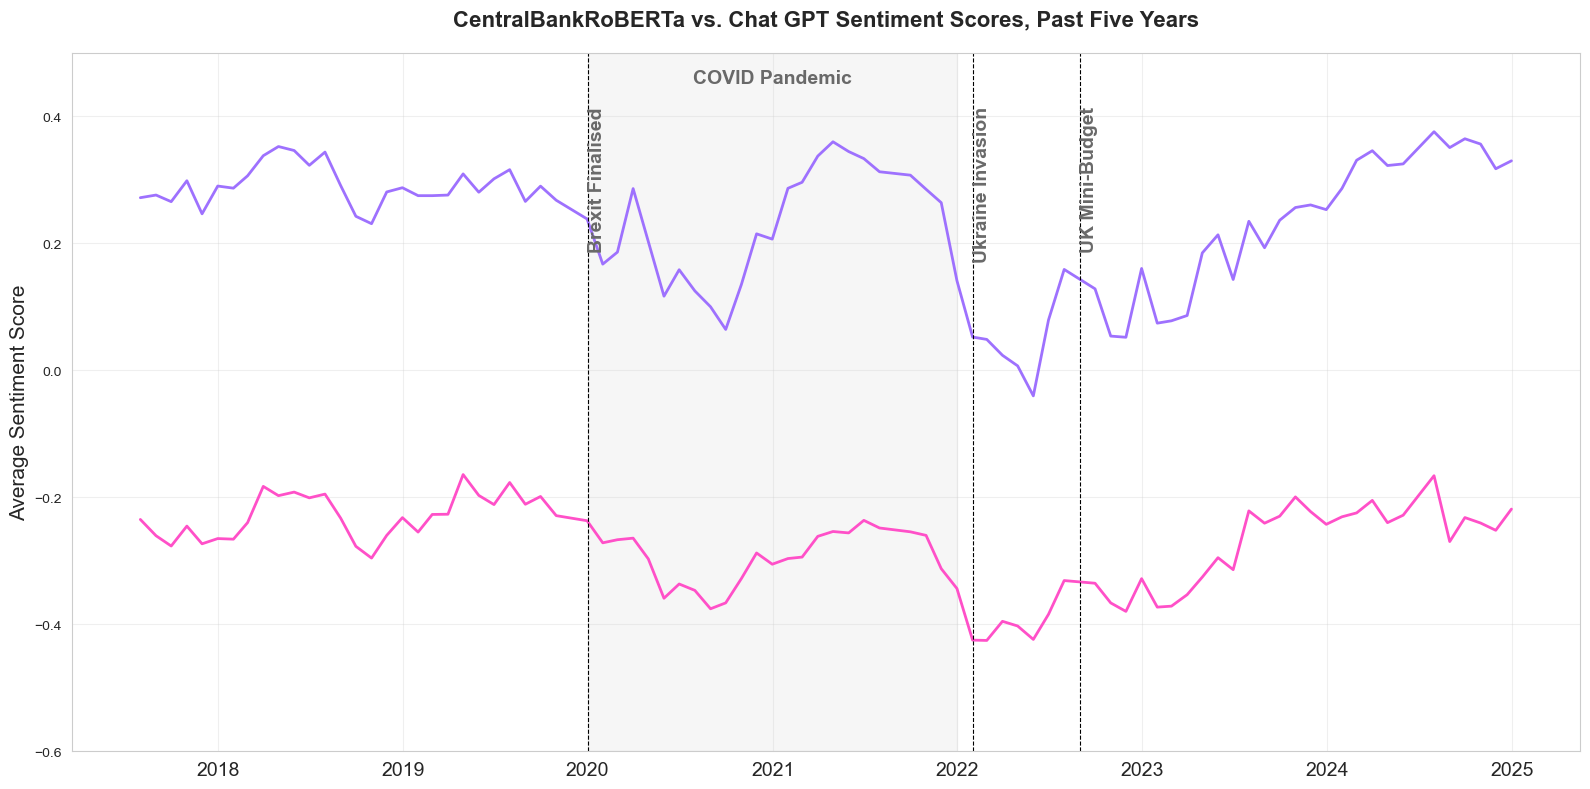

In [829]:
plt.figure(figsize=(16, 8))

# plt.plot(cbr_pfive_monthly, linewidth=1, color='lightgrey')
plt.plot(cbr_pfive_rolling_avg, label='CentralBankRoBERTa', linewidth=2, color='#FF50C8')
# plt.plot(gpt_monthly_sentiment, linewidth=1, color='lightgrey')
plt.plot(gpt_rolling_avg, label='Chat GPT', linewidth=2, color='#9E71FE')
# plt.plot(finbert_pfive_rolling_avg, label='FinBERT', linewidth=2, color='#3CD7D9')

# Add line at 0
# plt.axhline(y=0, color='gray', linestyle='--')

# Get current axes
ax = plt.gca()

# Get y-axis limits
y_max = ax.get_ylim()[1]
y_min = ax.get_ylim()[0]

# Set label position 
label_position = 1.05  
label_y_position = y_min + (y_max - y_min) * label_position

# Highlight periods
highlight_periods = {
    'COVID Pandemic': ('2020', '2022')
}

# Event lines
event_lines = {
    'Brexit Finalised': '2020',
    'Ukraine Invasion' : '2022-02', 
    'UK Mini-Budget': '2022-09',
}

# Add highlighted time periods
for label, (start, end) in highlight_periods.items():
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    ax.axvspan(start_date, end_date, color='lightgrey', alpha=0.2)
    # Add label in the center of the highlighted period
    ax.text((start_date + (end_date - start_date)/2), label_y_position, 
            label, ha='center', va='center', fontsize=14, color='dimgrey', weight='bold')

# Add event lines
for label, date in event_lines.items():
    event_date = pd.to_datetime(date)
    ax.axvline(event_date, color='black', linestyle='--', linewidth=0.8)
    ax.text(event_date, y_max*1, label, rotation=90, 
            va='top', ha='left', fontsize=14, color='dimgrey', weight='bold')

# Formatting
plt.title('CentralBankRoBERTa vs. Chat GPT Sentiment Scores, Past Five Years', 
          fontsize=16, weight='bold', pad=20)
plt.ylabel('Average Sentiment Score', size=15)
plt.xticks(fontsize=14)
plt.ylim(-0.6, 0.5)

# Add grid (assuming gridlines() was a custom function)
plt.grid(True, alpha=0.3)

# plt.legend(loc='lower right', fontsize=14)
plt.tight_layout()
plt.savefig('cbr_v_chatgpt.png', dpi=300)
plt.show()

**Observations:**
- CentralBankRoberta indeed has a more negative skew in scores.
- Chat GPT is a bit more volatile than CentralBankRoberta, which could be but is not necessarily a benefit.
- However, both models follow similar patterns of peaks and dips

In [528]:
# Viewing specific time periods to compare scores

# Convert each Series to DataFrame
gpt_monthly_sentiment_df = pd.DataFrame(gpt_monthly_sentiment).reset_index()
cbr_pfive_monthly_df = pd.DataFrame(cbr_pfive_monthly).reset_index()

# Merge dfs
gpt_cbr_merge = gpt_monthly_sentiment_df.merge(cbr_pfive_monthly_df, on='date')

# Reset date as index
gpt_cbr_merge = gpt_cbr_merge.set_index('date')

gpt_cbr_merge

gpt_cont_score  cbroberta_avg_score
date                                           
2017-01-31        0.175000            -0.233366
2017-02-28        0.412500            -0.187997
2017-03-31        0.085714            -0.363107
2017-04-30        0.500000            -0.135150
2017-06-30        0.237500            -0.165005
...                    ...                  ...
2024-08-31        0.300000            -0.538478
2024-09-30        0.300000            -0.163685
2024-10-31        0.400000            -0.163755
2024-11-30        0.066667            -0.325964
2024-12-31        0.375000            -0.072997

[91 rows x 2 columns]

In [534]:
# Generate correlation
gpt_cbr_merge[['gpt_cont_score', 'cbroberta_avg_score']].corr()

gpt_cont_score  cbroberta_avg_score
gpt_cont_score             1.000000             0.722134
cbroberta_avg_score        0.722134             1.000000

**Observation:** Chat GPT scores and CBRoBERTa scores are highly correlated.

In [530]:
# Filter by date range to look at specific values
gpt_cbr_merge = gpt_cbr_merge[(gpt_cbr_merge.index >= '2021-07-01') & (gpt_cbr_merge.index <= '2023-01-01')].sort_values(by='cbroberta_avg_score',
                                                                                                                         ascending=False)
gpt_cbr_merge

gpt_cont_score  cbroberta_avg_score
date                                           
2022-12-31        0.700000            -0.185896
2022-03-31        0.175000            -0.209265
2021-10-31        0.200000            -0.264503
2022-06-30        0.216667            -0.273823
2022-04-30        0.100000            -0.308653
2022-07-31        0.177778            -0.320397
2021-11-30        0.333333            -0.368403
2021-07-31        0.255556            -0.376597
2022-02-28        0.233333            -0.379613
2022-11-30        0.088889            -0.388805
2021-09-30        0.325000            -0.389766
2022-10-31       -0.271429            -0.395159
2022-09-30        0.050000            -0.404879
2022-05-31        0.050000            -0.495224
2021-12-31       -0.500000            -0.511034
2022-01-31       -0.300000            -0.639270

### Run correlations to compare CBR and Chat GPT

In [708]:
# Load in monthly corr data
month = pd.read_csv('sentiments_topics_monthly_indicators.csv')

# Filter for date range(
month = month[(month['date'] >= '2017-01-01')]

month.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507 entries, 157 to 663
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     507 non-null    object 
 1   custom_ref               507 non-null    object 
 2   reference                359 non-null    object 
 3   title                    507 non-null    object 
 4   author                   507 non-null    object 
 5   is_gov                   507 non-null    float64
 6   text                     507 non-null    object 
 7   finbert_pos              507 non-null    float64
 8   finbert_neg              507 non-null    float64
 9   finbert_neu              507 non-null    float64
 10  finbert_sentiment        507 non-null    object 
 11  finbert_score            507 non-null    float64
 12  finbert_confidence       507 non-null    float64
 13  central_bank             507 non-null    float64
 14  financial_sector         507 

In [710]:
# Drop unneeded cols in GPT df
gpt_data_for_merge = gpt_data[['custom_ref', 'gpt_cont_score']].reset_index().copy()
gpt_data_for_merge

date              custom_ref  gpt_cont_score
0   2017-01-13  UK_2017-01-13_saunders            -0.3
1   2017-01-16    UK_2017-01-16_Carney             0.2
2   2017-01-24    UK_2017-01-24_salmon             0.3
3   2017-01-25    UK_2017-01-25_Carney             0.5
4   2017-02-07    UK_2017-02-07_forbes             0.5
..         ...                     ...             ...
502 2024-11-25   UK_2024-11-25_Dhingra            -0.4
503 2024-12-02   UK_2024-12-02_Foulger             0.3
504 2024-12-03   UK_2024-12-03_Lintern             0.3
505 2024-12-09   UK_2024-12-09_Ramsden             0.2
506 2024-12-16   UK_2024-12-16_Cleland             0.7

[507 rows x 3 columns]

In [874]:
# Merge 
month_new = month.merge(gpt_data_for_merge, on='custom_ref')

# Drop unneeded cols
month_new= month_new.drop(['reference', 'title', 'author', 'is_gov',
       'text', 'finbert_pos', 'finbert_neg', 'finbert_neu',
       'finbert_sentiment', 'cbroberta_avg_sentiment', 'date_y', 'topic_0', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'dominant_topic',
       'dominant_topic_name'], axis=1)

# Rename date col
month_new = month_new.rename(columns={'date_x' : 'date'})
                           
month_new.columns

Index(['date', 'custom_ref', 'finbert_score', 'finbert_confidence',
       'central_bank', 'financial_sector', 'firms', 'government', 'households',
       'cbroberta_avg_score', 'month', 'cpi_rate', 'ftse_vix',
       'ftse_vix_pct_chg', 'gbp_usd_m', 'gfk_cc', 'hpi_mom', 'hpi_yoy',
       'avg_house_price', 'infl_exp', 'mortgage_approvals', 'mortgage_2yr',
       'mortgage_svr', 'rsi_mom', 'rsi_3mo3m', 'rsi_3mo3m1y', 'rsi_vol',
       'unemp_rate', 'wage_rate', 'pmi', 'gpt_cont_score'],
      dtype='object')

In [880]:
# View sentiment model correlations
sentiment_corr_df = month_new[['gpt_cont_score', 'finbert_score', 'cbroberta_avg_score']]
sentiment_corr_df.corr()

gpt_cont_score  finbert_score  cbroberta_avg_score
gpt_cont_score             1.000000       0.490495             0.687183
finbert_score              0.490495       1.000000             0.372254
cbroberta_avg_score        0.687183       0.372254             1.000000

**Observation:** Chat GPT and CBRoBERTa are more highly correlated with each other than FinBERT is to either.

In [868]:
# Convert to datetime
month_new['date'] = pd.to_datetime(month_new['date'])

# Extract sentiment columns
sentiment_columns = ['central_bank', 'financial_sector', 'firms', 'government', 'households', 'finbert_score',
       'cbroberta_avg_score', 'gpt_cont_score']

# Indicators to keep
core_indicators = ['cpi_rate', 'ftse_vix', 'gbp_usd_m', 'gfk_cc', 'hpi_yoy', 
                   'mortgage_approvals', 'mortgage_2yr', 'rsi_3mo3m', 
                   'unemp_rate', 'wage_rate', 'pmi']

# Aggregate by month
month_new['year_month'] = month_new['date'].dt.strftime('%Y-%m')
agg_dict = {}

# Average sentiment scores by month
for col in sentiment_columns:
    agg_dict[col] = 'mean'

# Take last value in month for indicators
for col in core_indicators:  # Changed from indicator_columns
    agg_dict[col] = 'last'

# Aggregate by month
monthly_data = month_new.groupby('year_month').agg(agg_dict).reset_index().copy()
monthly_data['date'] = pd.to_datetime(monthly_data['year_month'] + '-01')

# 6-month lag version
lag_periods = [6]  # Simplified to only 6-month lags
key_indicators_for_lags = ['cpi_rate', 'gbp_usd_m', 'gfk_cc', 'hpi_yoy', 'unemp_rate', 'wage_rate', 'mortgage_2yr']

for indicator in key_indicators_for_lags:
    if indicator in monthly_data.columns:
        for lag in lag_periods:
            monthly_data[f'{indicator}_future_{lag}m'] = monthly_data[indicator].shift(-lag)

# Lagged indicator list
lagged_indicators = [f'{ind}_future_{lag}m' for ind in key_indicators_for_lags
                     for lag in lag_periods if f'{ind}_future_{lag}m' in monthly_data.columns]

simplified_indicators = core_indicators + lagged_indicators  # Changed from indicator_columns

# Create correlation matrix
corr_matrix = monthly_data[sentiment_columns + simplified_indicators].corr()

# Extract sentiment vs indicators correlations
sentiment_indicator_corr = corr_matrix.loc[sentiment_columns, simplified_indicators]

In [864]:
sentiment_indicator_corr

cpi_rate  ftse_vix  gbp_usd_m    gfk_cc   hpi_yoy  \
central_bank        -0.107580  0.087687   0.036526  0.079132 -0.173628   
financial_sector    -0.059152  0.188158   0.115737  0.093799 -0.263809   
firms               -0.186046  0.325957   0.046580  0.133777 -0.243406   
government          -0.260041  0.261181   0.153636  0.159470 -0.058130   
households          -0.134730  0.317565   0.034713  0.095896 -0.173982   
finbert_score        0.133684  0.102586   0.164562 -0.027039  0.085643   
cbroberta_avg_score -0.021078  0.335765  -0.067568  0.030943 -0.230180   
cbroberta_avg_score -0.021078  0.335765  -0.067568  0.030943 -0.230180   
gpt_cont_score      -0.075612  0.291909   0.098209  0.079487 -0.179900   
gpt_cont_score      -0.075612  0.291909   0.098209  0.079487 -0.179900   

                     mortgage_approvals  mortgage_2yr  rsi_3mo3m  unemp_rate  \
central_bank                   0.025089      0.031974   0.039481    0.055407   
financial_sector               0.027185      0.192401   0.073264    0.073472   
firms                          0.042447      0.055309   0.116808    0.076093   
government                     0.216529     -0.001046   0.244272    0.199025   
households                     0.130963      0.023696   0.216072    0.143258   
finbert_score                  0.073548      0.098881   0.113601   -0.066779   
cbroberta_avg_score           -0.054639      0.101199   0.012929   -0.093369   
cbroberta_avg_score           -0.054639      0.101199   0.012929   -0.093369   
gpt_cont_score                 0.000117      0.058843   0.005249    0.025635   
gpt_cont_score                 0.000117      0.058843   0.005249    0.025635   

                     wage_rate  ...  cbroberta_avg_score  gpt_cont_score  \
central_bank          0.017073  ...             0.487449        0.363193   
financial_sector      0.183855  ...             0.517953        0.414272   
firms                 0.025436  ...             0.471147        0.361382   
government           -0.015135  ...             0.243675        0.199760   
households            0.030736  ...             0.437195        0.458302   
finbert_score         0.160272  ...             0.222854        0.211525   
cbroberta_avg_score   0.059284  ...             1.000000        0.734106   
cbroberta_avg_score   0.059284  ...             1.000000        0.734106   
gpt_cont_score        0.073152  ...             0.734106        1.000000   
gpt_cont_score        0.073152  ...             0.734106        1.000000   

                     gpt_cont_score  cpi_rate_future_6m  gbp_usd_m_future_6m  \
central_bank               0.363193           -0.181541             0.086572   
financial_sector           0.414272           -0.161964             0.076583   
firms                      0.361382           -0.293508             0.115294   
government                 0.199760           -0.246588             0.163673   
households                 0.458302           -0.245237             0.103379   
finbert_score              0.211525            0.208625            -0.115035   
cbroberta_avg_score        0.734106           -0.173470            -0.058568   
cbroberta_avg_score        0.734106           -0.173470            -0.058568   
gpt_cont_score             1.000000           -0.163859             0.065129   
gpt_cont_score             1.000000           -0.163859             0.065129   

                     gfk_cc_future_6m  hpi_yoy_future_6m  \
central_bank                 0.197464          -0.136371   
financial_sector             0.233593          -0.180663   
firms                        0.295050          -0.151237   
government                   0.185312           0.026610   
households                   0.302687          -0.189678   
finbert_score               -0.209352           0.063277   
cbroberta_avg_score          0.183316          -0.289216   
cbroberta_avg_score          0.183316          -0.289216   
gpt_cont_score               0.280922          -0.185752   
gpt_con

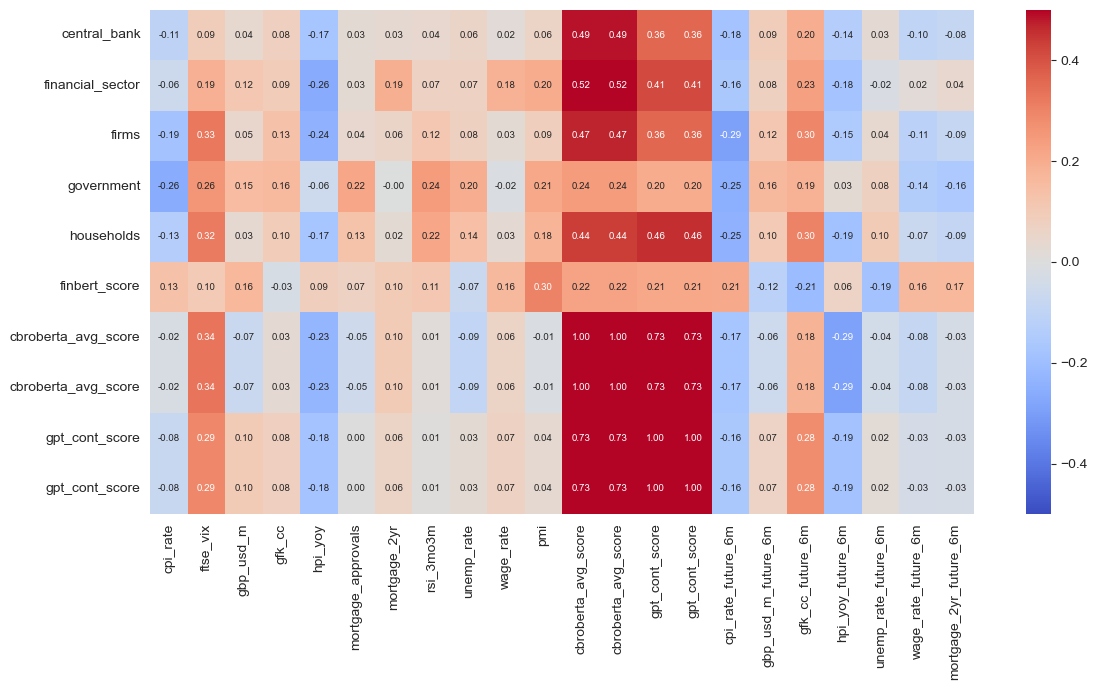

In [866]:
# Visualise correlations
plt.figure(figsize=(12,7))
sns.heatmap(sentiment_indicator_corr, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5, center=0, fmt='.2f',
           annot_kws={"size": 7})
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Daily indicators corr

In [686]:
# https://drive.google.com/file/d/10_oZvVfTf6MuovTsVjsL6p15AbWFrRms/view?usp=drive_link - sentiments_topics_daily_indicators.csv
file_id = '10_oZvVfTf6MuovTsVjsL6p15AbWFrRms'
# Create the direct download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the file locally
output_path = 'sentiments_topics_daily_indicators_local.csv' 
gdown.download(download_url, output_path, quiet=False)
# Read the downloaded file 
daily = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=10_oZvVfTf6MuovTsVjsL6p15AbWFrRms
To: C:\Users\katej\Desktop\LSE Data Analytics\4. Employer Project\BoE-Beacon\sentiments_topics_daily_indicators_local.csv
100%|██████████| 16.0M/16.0M [00:00<00:00, 29.8MB/s]


In [687]:
daily.columns

Index(['date', 'custom_ref', 'reference', 'title', 'author', 'is_gov', 'text',
       'finbert_pos', 'finbert_neg', 'finbert_neu', 'finbert_sentiment',
       'finbert_score', 'finbert_confidence', 'central_bank',
       'financial_sector', 'firms', 'government', 'households',
       'cbroberta_avg_score', 'cbroberta_avg_sentiment', 'ftse250', 'ftse100',
       'gilt_2y', 'gilt_10y', 'ois_1m', 'ois_3m', 'ois_6m', 'ois_12m', 'sonia',
       'vix', 'gbp_usd_d', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'dominant_topic',
       'dominant_topic_name'],
      dtype='object')

In [688]:
# Drop columns
daily_new = daily.drop(['reference', 'title', 'author', 'is_gov', 'text',
       'finbert_pos', 'finbert_neg', 'finbert_neu', 'finbert_sentiment',
       'finbert_score', 'finbert_confidence', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'dominant_topic',
       'dominant_topic_name'], axis=1)

# Filter for date range
daily_new = daily_new[(daily_new['date'] >= '2017-01-01')]

daily_new.head(2)

date              custom_ref  central_bank  financial_sector  \
157  2017-01-13  UK_2017-01-13_saunders     -0.412643         -0.611356   
158  2017-01-16    UK_2017-01-16_Carney     -0.503661         -0.582517   

        firms  government  households  cbroberta_avg_score  \
157 -0.349293   -0.520171   -0.373902            -0.384333   
158 -0.671746    0.022232   -0.530369            -0.532864   

     cbroberta_avg_sentiment   ftse250  ftse100  gilt_2y  gilt_10y  ois_1m  \
157                      0.0  18371.94  7337.81     0.18      1.43    0.21   
158                      0.0  18307.71  7327.13     0.15      1.39    0.21   

     ois_3m  ois_6m  ois_12m   sonia    vix  gbp_usd_d  
157    0.22    0.22     0.24  0.2127  11.23     1.2198  
158    0.22    0.22     0.24  0.2125    NaN        NaN

In [689]:
# Merge 
daily_new = daily_new.merge(gpt_data_for_merge, on='custom_ref')

# Drop second date col
daily_new = daily_new.drop('date_y', axis=1)
# Rename date col
daily_new = daily_new.rename(columns={'date_x' : 'date'})
                           
daily_new.columns

Index(['date', 'custom_ref', 'central_bank', 'financial_sector', 'firms',
       'government', 'households', 'cbroberta_avg_score',
       'cbroberta_avg_sentiment', 'ftse250', 'ftse100', 'gilt_2y', 'gilt_10y',
       'ois_1m', 'ois_3m', 'ois_6m', 'ois_12m', 'sonia', 'vix', 'gbp_usd_d',
       'gpt_cont_score'],
      dtype='object')

In [668]:
# Convert to datetime
daily_new['date'] = pd.to_datetime(daily_new['date'])

# Extract sentiment columns
sentiment_columns = ['central_bank', 'financial_sector', 'firms', 'government', 'households',
                    'cbroberta_avg_score', 'gpt_cont_score']

# Daily indicators available in daily_new
indicator_columns = ['ftse250', 'ftse100', 'gilt_2y', 'gilt_10y', 
                    'ois_1m', 'ois_3m', 'ois_6m', 'ois_12m', 'sonia', 'vix', 'gbp_usd_d']

# Filter to only include indicators that exist in the data
indicator_columns = [col for col in indicator_columns if col in daily_new.columns]

# Sort by date for proper lagging
daily_data = daily_new.sort_values('date').copy()

# Create lagged versions of indicators
lag_periods = [6]  # 6-day lags for daily data
key_indicators_for_lags = ['gilt_2y', 'gilt_10y', 'ftse100', 'vix', 'gbp_usd_d']

for indicator in key_indicators_for_lags:
    if indicator in daily_data.columns:
        for lag in lag_periods:
            daily_data[f'{indicator}_future_{lag}d'] = daily_data[indicator].shift(-lag)

# Create lagged indicator list
lagged_indicators = [f'{ind}_future_{lag}d' for ind in key_indicators_for_lags
                     for lag in lag_periods if f'{ind}_future_{lag}d' in daily_data.columns]

simplified_indicators = indicator_columns + lagged_indicators

# Create correlation matrix
corr_matrix = daily_data[sentiment_columns + simplified_indicators].corr()

# Extract sentiment vs indicators correlations
sentiment_indicator_corr = corr_matrix.loc[sentiment_columns, simplified_indicators]

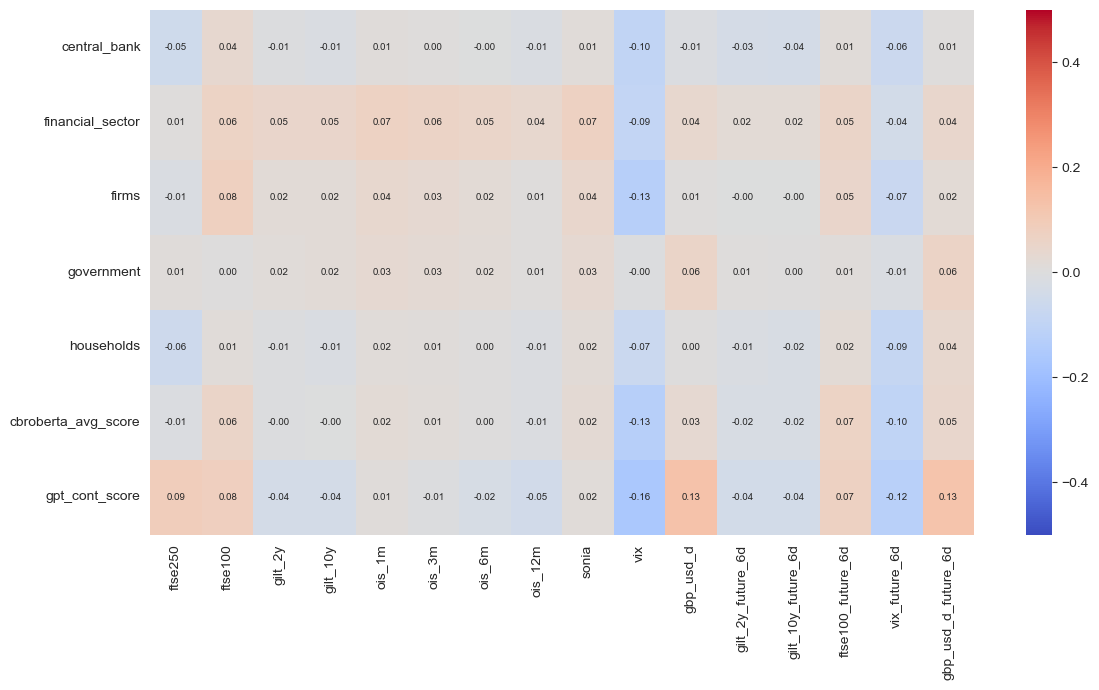

In [670]:
# Visualise correlations
plt.figure(figsize=(12,7))
sns.heatmap(sentiment_indicator_corr, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5, center=0, fmt='.2f',
           annot_kws={"size": 7})
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Quarterly indicators

In [674]:
# https://drive.google.com/file/d/1meab0mOcECv82QPYkXd1jXtlik73EO5V/view?usp=drive_link - sentiments_topics_quarterly_indicators.csv
file_id = '1meab0mOcECv82QPYkXd1jXtlik73EO5V'
# Create the direct download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the file locally
output_path = 'sentiments_topics_quarterly_indicators_local.csv' 
gdown.download(download_url, output_path, quiet=False)
# Read the downloaded file 
quarterly = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=1meab0mOcECv82QPYkXd1jXtlik73EO5V
To: C:\Users\katej\Desktop\LSE Data Analytics\4. Employer Project\BoE-Beacon\sentiments_topics_quarterly_indicators_local.csv
100%|██████████| 15.8M/15.8M [00:00<00:00, 28.9MB/s]


In [676]:
quarterly.columns

Index(['date', 'custom_ref', 'reference', 'title', 'author', 'is_gov', 'text',
       'finbert_pos', 'finbert_neg', 'finbert_neu', 'finbert_sentiment',
       'finbert_score', 'finbert_confidence', 'central_bank',
       'financial_sector', 'firms', 'government', 'households',
       'cbroberta_avg_score', 'cbroberta_avg_sentiment', 'month', 'quarter',
       'cpi_rate', 'gdp_rate', 'household_debt', 'loans_to_pvt_sector',
       'unemp_rate', 'business_confidence', 'consumer_spending', 'wage_rate',
       'rsi_3mo3m', 'rsi_vol', 'house_price_change', 'gfk_avg_cc_qrt',
       'infl_exp_qrt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
       'topic_5', 'topic_6', 'topic_7', 'dominant_topic',
       'dominant_topic_name'],
      dtype='object')

In [684]:
# Drop cols
quarterly_new = quarterly.drop(['reference', 'title', 'author', 'is_gov', 'text',
       'finbert_pos', 'finbert_neg', 'finbert_neu', 'finbert_sentiment',
       'finbert_score', 'finbert_confidence', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'dominant_topic',
       'dominant_topic_name'], axis=1)

# Filter for date range
quarterly_new = quarterly_new[(quarterly_new['date'] >= '2017-01-01')]

quarterly_new.head(2)

date              custom_ref  central_bank  financial_sector  \
157  2017-01-13  UK_2017-01-13_saunders     -0.412643         -0.611356   
158  2017-01-16    UK_2017-01-16_Carney     -0.503661         -0.582517   

        firms  government  households  cbroberta_avg_score  \
157 -0.349293   -0.520171   -0.373902            -0.384333   
158 -0.671746    0.022232   -0.530369            -0.532864   

     cbroberta_avg_sentiment    month  ... loans_to_pvt_sector  unemp_rate  \
157                      0.0  2017-01  ...           2321019.0         4.6   
158                      0.0  2017-01  ...           2321019.0         4.6   

     business_confidence  consumer_spending  wage_rate  rsi_3mo3m  rsi_vol  \
157                 15.0           372376.0       2.03       -1.3     94.6   
158                 15.0           372376.0       2.03       -1.3     94.6   

     house_price_change  gfk_avg_cc_qrt  infl_exp_qrt  
157                 0.5           -5.67          2.57  
158                 0.5           -5.67          2.57  

[2 rows x 24 columns]

In [694]:
# Merge 
quarterly_new = quarterly_new.merge(gpt_data_for_merge, on='custom_ref')

# Drop second date col
quarterly_new = quarterly_new.drop('date_y', axis=1)
# Rename date col
quarterly_new = quarterly_new.rename(columns={'date_x' : 'date'})
                           
quarterly_new.columns

Index(['date', 'custom_ref', 'central_bank', 'financial_sector', 'firms',
       'government', 'households', 'cbroberta_avg_score',
       'cbroberta_avg_sentiment', 'month', 'quarter', 'cpi_rate', 'gdp_rate',
       'household_debt', 'loans_to_pvt_sector', 'unemp_rate',
       'business_confidence', 'consumer_spending', 'wage_rate', 'rsi_3mo3m',
       'rsi_vol', 'house_price_change', 'gfk_avg_cc_qrt', 'infl_exp_qrt',
       'gpt_cont_score'],
      dtype='object')

In [696]:
# Convert to datetime
quarterly_new['date'] = pd.to_datetime(quarterly_new['date'])

# Extract sentiment columns (same as daily)
sentiment_columns = ['central_bank', 'financial_sector', 'firms', 'government', 'households',
                    'cbroberta_avg_score', 'gpt_cont_score']

# Quarterly indicators available in quarterly_new
indicator_columns = ['cpi_rate', 'gdp_rate', 'household_debt', 'loans_to_pvt_sector', 
                    'unemp_rate', 'business_confidence', 'consumer_spending', 'wage_rate', 
                    'rsi_3mo3m', 'rsi_vol', 'house_price_change', 'gfk_avg_cc_qrt', 'infl_exp_qrt']

# Filter to only include indicators that exist in the data
indicator_columns = [col for col in indicator_columns if col in quarterly_new.columns]

# Sort by date for proper lagging
quarterly_data = quarterly_new.sort_values('date').copy()

# Create lagged versions of indicators
lag_periods = [1, 2]  # 1 and 2 quarter lags for quarterly data
key_indicators_for_lags = ['gdp_rate', 'cpi_rate', 'unemp_rate', 'business_confidence', 'consumer_spending']

for indicator in key_indicators_for_lags:
    if indicator in quarterly_data.columns:
        for lag in lag_periods:
            quarterly_data[f'{indicator}_future_{lag}q'] = quarterly_data[indicator].shift(-lag)

# Create lagged indicator list
lagged_indicators = [f'{ind}_future_{lag}q' for ind in key_indicators_for_lags
                     for lag in lag_periods if f'{ind}_future_{lag}q' in quarterly_data.columns]

simplified_indicators = indicator_columns + lagged_indicators

# Create correlation matrix
corr_matrix = quarterly_data[sentiment_columns + simplified_indicators].corr()

# Extract sentiment vs indicators correlations
sentiment_indicator_corr = corr_matrix.loc[sentiment_columns, simplified_indicators]

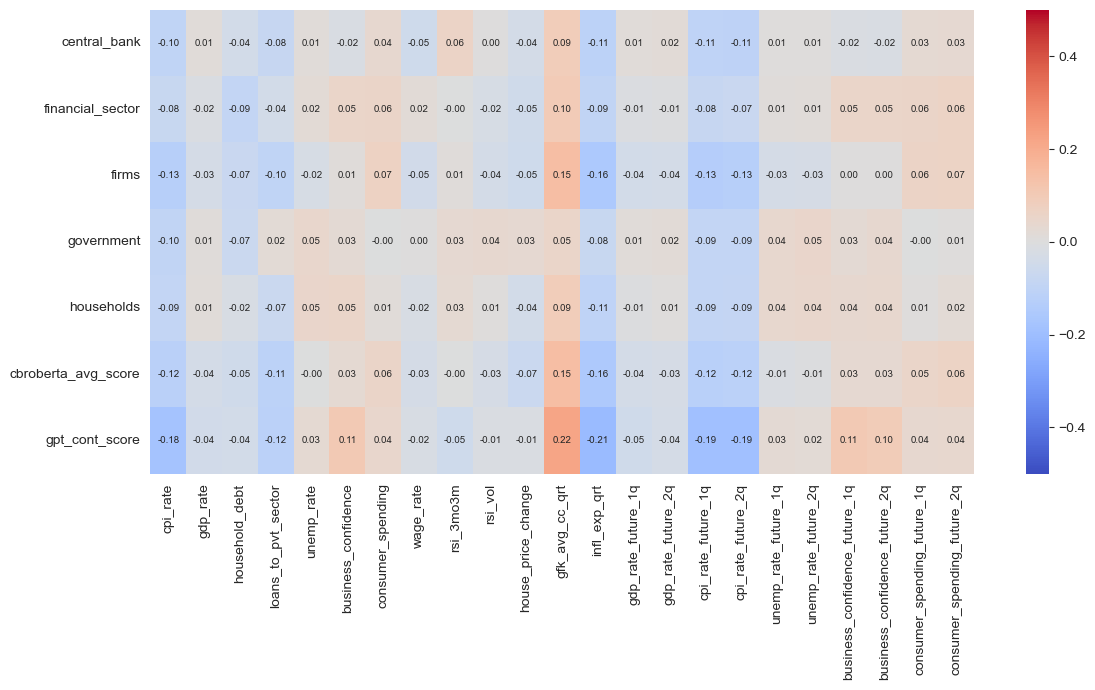

In [698]:
# Visualise correlations
plt.figure(figsize=(12,7))
sns.heatmap(sentiment_indicator_corr, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5, center=0, fmt='.2f',
           annot_kws={"size": 7})
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Financial methods comparison

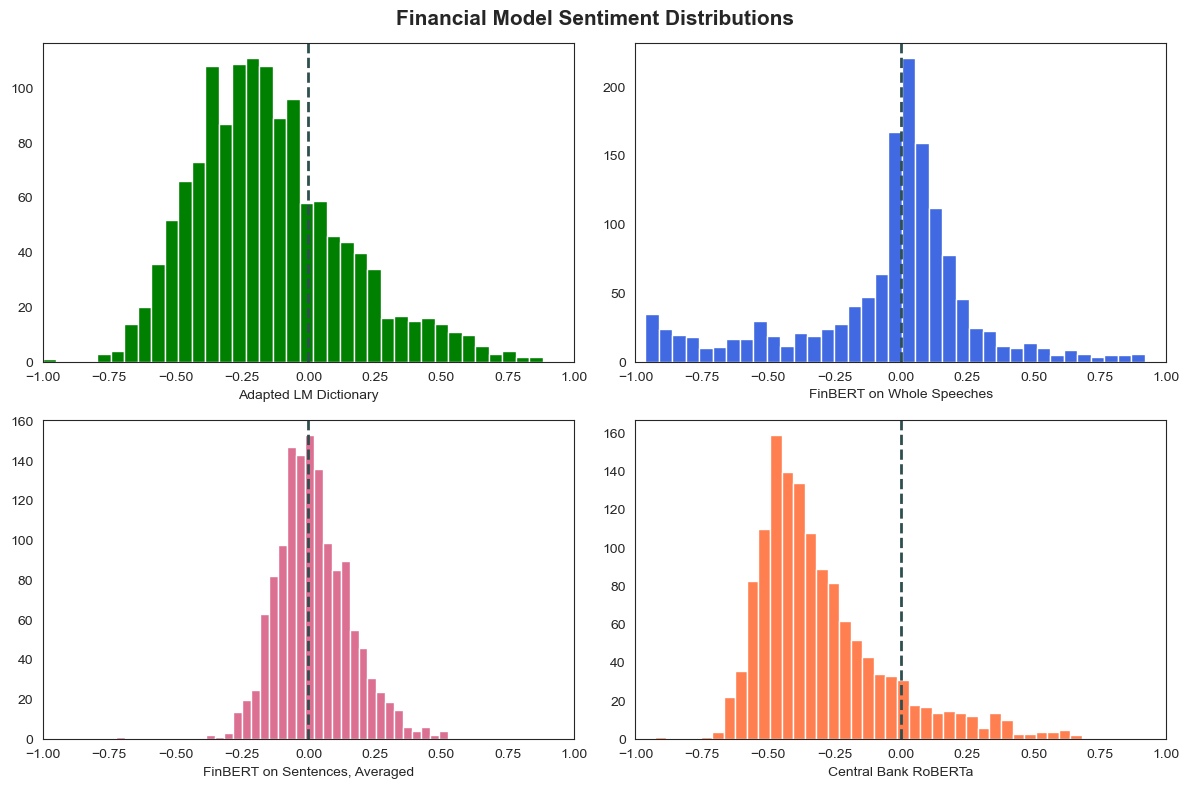

In [504]:
# Show overall scores comparison
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.hist(boesl_data['sentiment_ratio'], bins=37, color='green')
plt.axvline(x=0, color='darkslategrey', linestyle='--', linewidth=2)
plt.xlim(-1, 1)
plt.xlabel('Adapted LM Dictionary')

plt.subplot(2,2,2)
plt.hist(fbert_data['finbert_score'], bins=37, color='royalblue')
plt.axvline(x=0, color='darkslategrey', linestyle='--', linewidth=2)
plt.xlim(-1, 1)
plt.xlabel('FinBERT on Whole Speeches')

plt.subplot(2,2,3)
plt.hist(fb_data_sentence['sentiment_score'], bins=37, color='palevioletred')
plt.axvline(x=0, color='darkslategrey', linestyle='--', linewidth=2)
plt.xlim(-1, 1)
plt.xlabel('FinBERT on Sentences, Averaged')

plt.subplot(2,2,4)
plt.hist(agent_sentiment_pivot['cbroberta_avg_score'], bins=37, color='coral')
plt.axvline(x=0, color='darkslategrey', linestyle='--', linewidth=2)
plt.xlim(-1, 1)
plt.xlabel('Central Bank RoBERTa')

plt.suptitle('Financial Model Sentiment Distributions', weight='bold', size=15)

plt.tight_layout()
plt.savefig('hist_comp2.png', dpi=300)
plt.show()

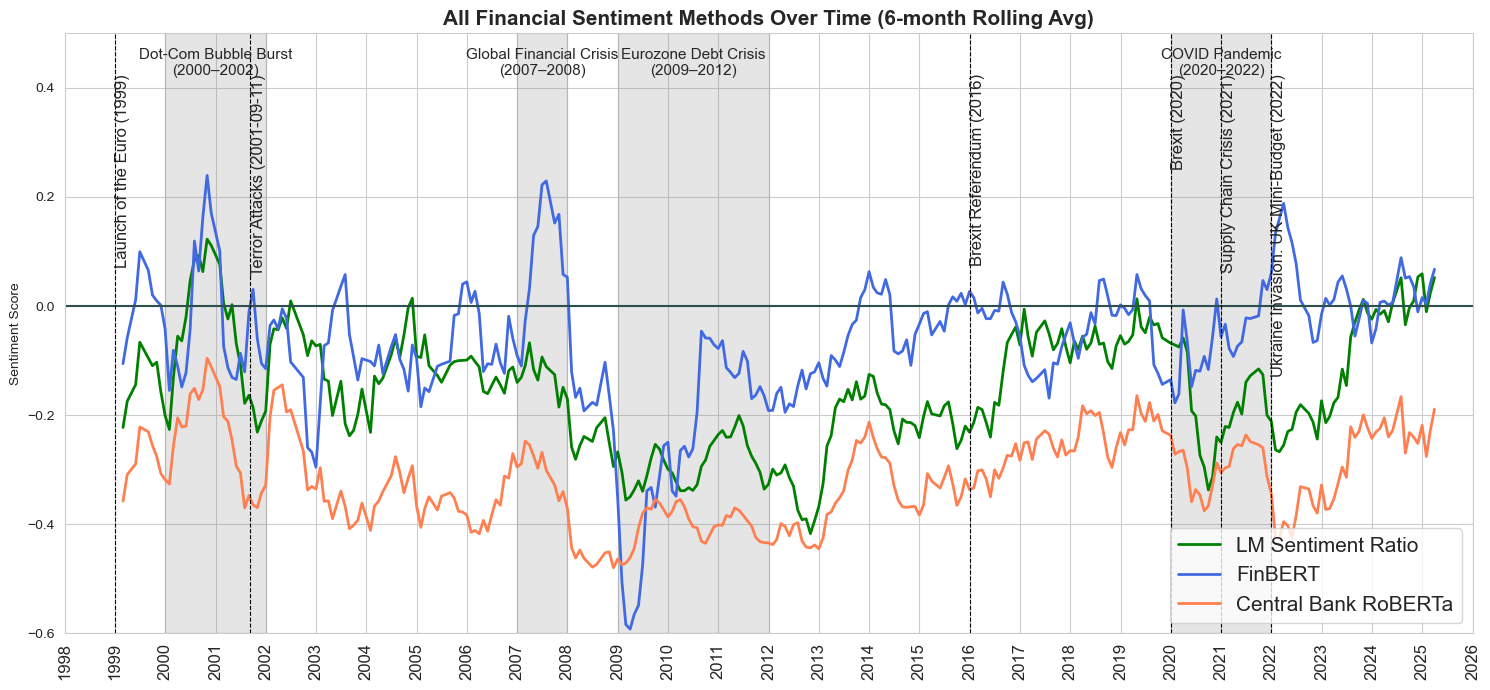

In [286]:
# Plot all methods
plt.figure(figsize=(15,7))

plt.plot(rat_rolling_avg, label='LM Sentiment Ratio', linewidth=2, color='green')
plt.plot(fb_rolling_avg, label='FinBERT', linewidth=2, color='royalblue')
# plt.plot(fb2_rolling_avg, label='FinBERT on sentences', linewidth=2, color='palevioletred')
plt.plot(cbr_rolling_avg, label='Central Bank RoBERTa', linewidth=2, color='coral')

# Add line at 0
plt.axhline(y=0, color='darkslategrey')

# Labels and formats
plt.title('All Financial Sentiment Methods Over Time (6-month Rolling Avg)', fontsize=15, weight='bold')
plt.ylabel('Sentiment Score')
# gridlines()
year_format(monthly_sentiment_density)
plt.ylim(-0.6,0.5)
milestones(label_position=0.95)

plt.legend(loc = 'lower right', fontsize=15)
plt.tight_layout()
plt.savefig('timeline_comp2.png', dpi=300, bbox_inches='tight')
plt.show()

### Compare FinBERT vs. Financial Sector CB RoBERTa

In [1222]:
agent_sentiment_agg.head()

cbroberta_agent  cbroberta_score
date                                       
1998-09-15    central_bank        -0.409745
1998-10-21    central_bank        -0.255258
1998-11-01    central_bank        -0.523060
1998-11-19    central_bank        -0.464046
1998-12-01    central_bank        -0.578633

In [1241]:
# Filter for financial sector only
fin_sec = agent_sentiment_agg[agent_sentiment_agg['cbroberta_agent'] == 'financial_sector']

# Set rolling average for fin_sec
fin_sec_resample = agent_sentiment_agg['cbroberta_score'].resample('ME').mean().dropna()
fin_sec_rolling = fin_sec_resample.rolling(window=6, min_periods=6).mean()

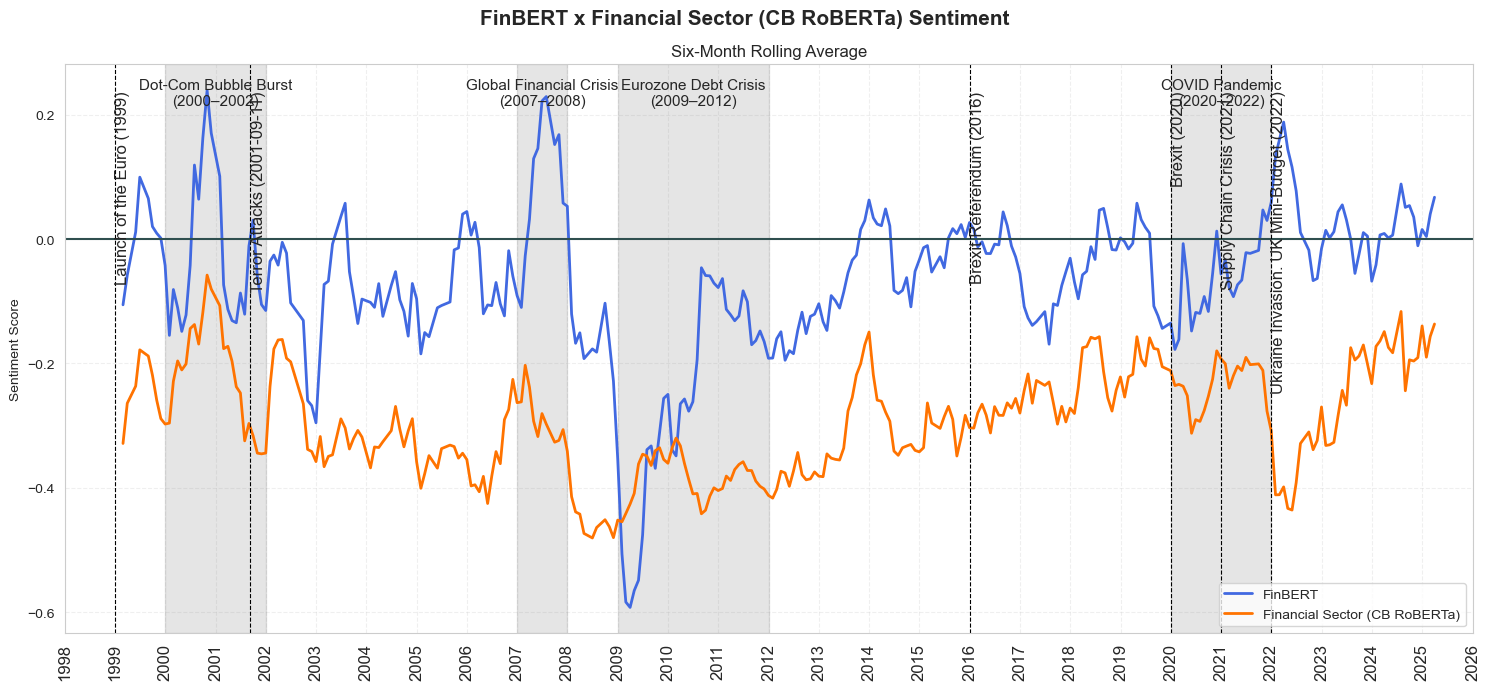

In [1243]:
# Plot Financial Sector CB RoBERTa vs. FinBERT
plt.figure(figsize=(15,7))

plt.plot(fb_rolling_avg, label='FinBERT', linewidth=2, color='royalblue')
plt.plot(fin_sec_rolling, label='Financial Sector (CB RoBERTa)', linewidth=2, color='#FF7300')

# Add line at 0
plt.axhline(y=0, color='darkslategrey')

# Labels and formats
plt.suptitle('FinBERT x Financial Sector (CB RoBERTa) Sentiment', fontsize=15, weight='bold')
plt.title('Six-Month Rolling Average')
plt.ylabel('Sentiment Score')
gridlines()
year_format(fb_rolling_avg)
# plt.ylim(-0.6,0.5)
milestones(label_position=0.95)

plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()

**Observations:**
- LM Sentiment Ratio is the most appropriate LM scoring method for comparison with FinBERT due to its scale.
- FinBERT sentiment appears more volatile than LM dictionary sentiment.
- The start Eurozone Debt Crisis results in the lowest sentiment (according to FinBERT).

# Pos, Neg, Neutral Words - FinBERT

In [130]:
# Lemmatise
fbert_data['lemm'] = fbert_data['tokens'].apply(lemmatize_tokens)

In [131]:
pos_label = fbert_data[fbert_data['finbert_sentiment'] == 'positive']
neg_label = fbert_data[fbert_data['finbert_sentiment'] == 'negative']
neu_label = fbert_data[fbert_data['finbert_sentiment'] == 'neutral']

## Top pos and neg speeches

In [133]:
# Subset top 20 positive and negative speeches
pos_speech = fbert_data.nlargest(20, 'finbert_score')
neg_speech = fbert_data.nsmallest(20, 'finbert_score')

In [134]:
pos_speech.to_csv('pos_speech.csv')
neg_speech.to_csv('neg_speech.csv')

In [206]:
# Unify all text by sentiment
pos_top = ' '.join([' '.join(text) for text in pos_speech['lemm']])
neg_top = ' '.join([' '.join(text) for text in neg_speech['lemm']])

# Add custom stopwords
c_stop = set(['uk', 'not', 'bank', 'economy', 'would', 'also'])


# Create a word cloud - pos
pos_text_cloud = WordCloud(width=1600, height=900,
                           min_font_size=10,
                           max_words=70,
                           background_color='white',
                           stopwords=c_stop,
                           colormap='Set2').generate(pos_top)

# Create a word cloud - neg
neg_text_cloud = WordCloud(width=1600, height=900,
                           min_font_size=10,
                           max_words=70,
                           background_color='white',
                           stopwords=c_stop,
                           colormap='Set2').generate(neg_top)

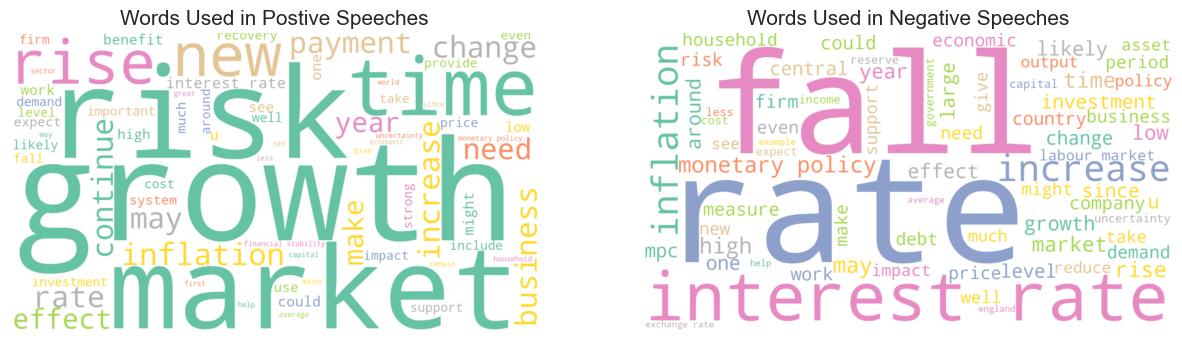

In [207]:
plt.figure(figsize=(15,7))

# Plot pos word cloud
plt.subplot(1,2,1)
plt.imshow(pos_text_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words Used in Postive Speeches', fontsize=15)

# Plot neg word cloud
plt.subplot(1,2,2)
plt.imshow(neg_text_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words Used in Negative Speeches', fontsize=15)
plt.show()

## All pos/neg/neutral

In [ ]:
# Unify all text by sentiment
pos_text = ' '.join([' '.join(text) for text in pos_label['lemm']])
neg_text = ' '.join([' '.join(text) for text in neg_label['lemm']])
neu_text = ' '.join([' '.join(text) for text in neu_label['lemm']])

# Add custom stopwords
# c_stop = set(['uk'])


# Create a word cloud - pos
pos_text_cloud = WordCloud(width=1600, height=900,
                         min_font_size=10,
                         max_words=70,
                         background_color='white',
                         colormap='Set2').generate(pos_text)

# Create a word cloud - neg
neg_text_cloud = WordCloud(width=1600, height=900,
                         min_font_size=10,
                         max_words=70,
                         background_color='white',
                         colormap='Set2').generate(neg_text)

# Create a word cloud - neu
neu_text_cloud = WordCloud(width=1600, height=900,
                         min_font_size=10,
                         max_words=100,
                         background_color='white',
                         colormap='Set2').generate(neu_text)

In [ ]:
# Plot pos word cloud
plt.figure(figsize=(10,8))
plt.imshow(pos_text_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words Used in Postive Speeches', fontsize=15)
plt.show()

In [ ]:
# Plot neg word cloud
plt.figure(figsize=(10,8))
plt.imshow(neg_text_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words Used in Negative Speeches', fontsize=15)
plt.show()

In [ ]:
# Plot neutral word cloud
plt.figure(figsize=(10,8))
plt.imshow(neu_text_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words Used in Neutral Speeches', fontsize=15)
plt.show()   

# TextBlob

In [414]:
# Make a copy
tb_data = uk_data.copy()

In [416]:
# TextBlob functions for polarity and subjectivity
def generate_polarity(comment):
    '''Extract polarity score (-1 to +1) for each comment'''
    return TextBlob(comment).sentiment[0]

def generate_subjectivity(comment):
    return TextBlob(comment).sentiment[1]

In [418]:
tb_data['tb_polarity'] = tb_data['clean_text'].apply(generate_polarity)
tb_data['tb_subjectivity'] = tb_data['clean_text'].apply(generate_subjectivity)

tb_data.head()

reference country       date  \
262  r980915a_BOE      UK 1998-09-15   
286  r981021b_BOE      UK 1998-10-21   
287  r981021a_BOE      UK 1998-10-21   
297  r981101a_BOE      UK 1998-11-01   
298  r981101b_BOE      UK 1998-11-01   

                                                 title         author  is_gov  \
262                                             Speech  Edward George     1.0   
286                                  Britain in Europe  Edward George     1.0   
287  Impact of the recent turbulence in internation...    Mervyn King     0.0   
297        Economic policy, with and without forecasts           budd     0.0   
298  Inflation targeting in practice: the UK experi...        vickers     0.0   

                                                  text  \
262  Thank you, Chairman. I'm actually very pleased...   
286  It's a great pleasure to be here in the beauti...   
287  Few industries have suffered more from volatil...   
297  My topic this evening is the use of forecasts ...   
298  Six years ago this week, sterling left the exc...   

                                            clean_text  \
262  thank chairman actually pleased opportunity re...   
286  great pleasure beautiful city bruges honoured ...   
287  industries suffered volatility british economy...   
297  topic evening use forecasts economic policy ma...   
298  six years ago week sterling left exchange rate...   

                                                tokens  tb_polarity  \
262  [thank, chairman, actually, pleased, opportuni...     0.063429   
286  [great, pleasure, beautiful, city, bruges, hon...     0.065732   
287  [industries, suffered, volatility, british, ec...     0.064783   
297  [topic, evening, use, forecasts, economic, pol...     0.058212   
298  [six, years, ago, week, sterling, left, exchan...     0.048416   

     tb_subjectivity  
262         0.419275  
286         0.348762  
287         0.380794  
297         0.465414  
298         0.386632

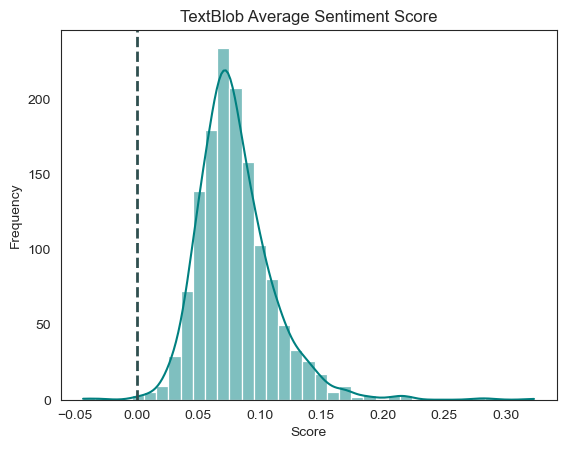

In [434]:
# View polarity
sns.histplot(tb_data['tb_polarity'], kde=True, bins=37, color='teal')
plt.title('TextBlob Average Sentiment Score')
plt.xlabel('Score')
# plt.xlim(-1,1)
plt.ylabel('Frequency')
plt.axvline(x=0, color='darkslategrey', linestyle='--', linewidth=2)
plt.show()

In [430]:
tb_data['tb_polarity'].describe()

count    1374.000000
mean        0.079979
std         0.031403
min        -0.043709
25%         0.060593
50%         0.075797
75%         0.094465
max         0.323077
Name: tb_polarity, dtype: float64

# VADER

In [441]:
vader_data = uk_data.copy()

In [449]:
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return analyzer.polarity_scores(text)

In [453]:
# Apply VADER sentiment analyser
vader_data['vader_sentiment'] = vader_data['clean_text'].apply(analyze_sentiment)

# Expand scores to separate cols
vader_data = vader_data.join(vader_data['vader_sentiment'].apply(pd.Series))

# Drop original vader col
vader_data = vader_data.drop(columns=['vader_sentiment'])

# Add VADER sentiment groupings
vader_data['Sentiment']=''
vader_data.loc[vader_data.compound >= 0.05,'Sentiment']='Positive'
vader_data.loc[(vader_data.compound > -0.05) & (vader_data.compound < 0.05),'Sentiment']='Neutral'
vader_data.loc[vader_data.compound <= -0.05,'Sentiment']='Negative'

pd.reset_option('display.max_colwidth')
vader_data.head()

reference country       date  \
262  r980915a_BOE      UK 1998-09-15   
286  r981021b_BOE      UK 1998-10-21   
287  r981021a_BOE      UK 1998-10-21   
297  r981101a_BOE      UK 1998-11-01   
298  r981101b_BOE      UK 1998-11-01   

                                                 title         author  is_gov  \
262                                             Speech  Edward George     1.0   
286                                  Britain in Europe  Edward George     1.0   
287  Impact of the recent turbulence in internation...    Mervyn King     0.0   
297        Economic policy, with and without forecasts           budd     0.0   
298  Inflation targeting in practice: the UK experi...        vickers     0.0   

                                                  text  \
262  Thank you, Chairman. I'm actually very pleased...   
286  It's a great pleasure to be here in the beauti...   
287  Few industries have suffered more from volatil...   
297  My topic this evening is the use of forecasts ...   
298  Six years ago this week, sterling left the exc...   

                                            clean_text  \
262  thank chairman actually pleased opportunity re...   
286  great pleasure beautiful city bruges honoured ...   
287  industries suffered volatility british economy...   
297  topic evening use forecasts economic policy ma...   
298  six years ago week sterling left exchange rate...   

                                                tokens    neg    neu    pos  \
262  [thank, chairman, actually, pleased, opportuni...  0.144  0.700  0.156   
286  [great, pleasure, beautiful, city, bruges, hon...  0.099  0.684  0.217   
287  [industries, suffered, volatility, british, ec...  0.112  0.728  0.160   
297  [topic, evening, use, forecasts, economic, pol...  0.077  0.787  0.136   
298  [six, years, ago, week, sterling, left, exchan...  0.092  0.783  0.125   

     compound Sentiment  
262    0.9846  Positive  
286    0.9998  Positive  
287    0.9957  Positive  
297    0.9993  Positive  
298    0.9983  Positive

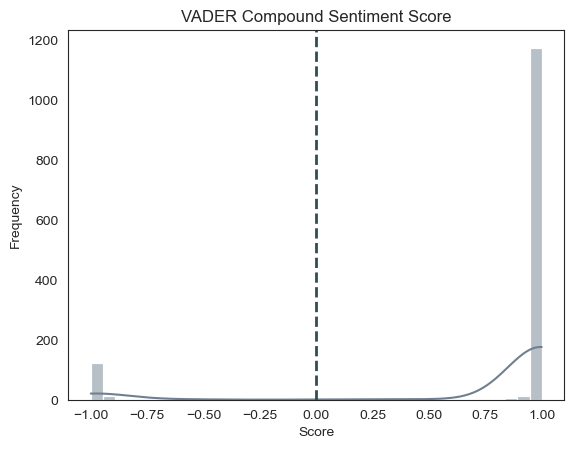

In [455]:
# View compound
sns.histplot(vader_data['compound'], kde=True, bins=37, color='slategray')
plt.title('VADER Compound Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='darkslategrey', linestyle='--', linewidth=2)
plt.show()